In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from time import sleep

import sys
sys.path.insert(1, "/media/data/kaggle/predict-future-sales")
from src import translate

%matplotlib inline

In [184]:
%run -i "../src/read_data.py"

In [3]:
sales_train.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [4]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
sales_train["date"] = pd.to_datetime(sales_train["date"], format="%d.%m.%Y")

In [6]:
sales_train.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

date_block_num      shop_id      item_id   item_price item_cnt_day
count    2.93585e+06  2.93585e+06  2.93585e+06  2.93585e+06  2.93585e+06
mean         14.5699      33.0017      10197.2      890.853      1.24264
std          9.42299       16.227       6324.3       1729.8      2.61883
min                0            0            0           -1          -22
25%                7           22         4476          249            1
50%               14           31         9343          399            1
75%               23           47        15684          999            1
max               33           59        22169       307980         2169

**item_price** - big standard deviation, negative values (`-1`) and some outliers (e.g. 307980)

**item_cnt_day** - big standard deviation (> twice the mean), negative values (e.g. -22) and some outliers (e.g 2169)

In [7]:
sales_train = sales_train.astype({"date_block_num": np.int8, "shop_id": np.int8, "item_id": np.int16, 
                                  "item_price": np.float32, "item_cnt_day": np.int32})

In [8]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int8          
 2   shop_id         int8          
 3   item_id         int16         
 4   item_price      float32       
 5   item_cnt_day    int32         
dtypes: datetime64[ns](1), float32(1), int16(1), int32(1), int8(2)
memory usage: 56.0 MB


In [9]:
sales_train.isnull().sum(axis=0)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [10]:
sales_train.sort_values(["date", "date_block_num", "shop_id", "item_id"], inplace=True)

In [11]:
sales_train = sales_train \
    .merge(items, on="item_id", how="left") \
    .merge(item_categories, on="item_category_id", how="left") \
    .merge(shops, on="shop_id", how = "left")

In [12]:
sales_train_by_month = sales_train \
    .groupby(["shop_id", "item_id", sales_train["date"].dt.to_period("M").dt.to_timestamp()]) \
    [["item_price", "item_cnt_day"]] \
    .agg({"item_price": [np.mean, np.median], "item_cnt_day": np.sum}) \
    .reset_index()
sales_train_by_month.columns = ["_".join(col[::-1]).strip("_") for col in sales_train_by_month.columns]
sales_train_by_month.rename({"sum_item_cnt_day": "item_cnt_month"}, axis=1, inplace=True)

In [13]:
sales_train_by_month = sales_train_by_month \
    .merge(items, on="item_id", how="left") \
    .merge(item_categories, on="item_category_id", how="left") \
    .merge(shops, on="shop_id", how = "left")

# Explore shops information

In [14]:
shops

shop_name  shop_id  \
0                     !Якутск Орджоникидзе, 56 фран        0   
1                     !Якутск ТЦ "Центральный" фран        1   
2                                  Адыгея ТЦ "Мега"        2   
3                    Балашиха ТРК "Октябрь-Киномир"        3   
4                          Волжский ТЦ "Волга Молл"        4   
5                            Вологда ТРЦ "Мармелад"        5   
6                        Воронеж (Плехановская, 13)        6   
7                            Воронеж ТРЦ "Максимир"        7   
8                      Воронеж ТРЦ Сити-Парк "Град"        8   
9                                 Выездная Торговля        9   
10                       Жуковский ул. Чкалова 39м?       10   
11                       Жуковский ул. Чкалова 39м²       11   
12                              Интернет-магазин ЧС       12   
13                              Казань ТЦ "Бехетле"       13   
14                          Казань ТЦ "ПаркХаус" II       14   
15                             Калуга ТРЦ "XXI век"       15   
16                                 Коломна ТЦ "Рио"       16   
17                    Красноярск ТЦ "Взлетка Плаза"       17   
18                             Красноярск ТЦ "Июнь"       18   
19                            Курск ТЦ "Пушкинский"       19   
20                              Москва "Распродажа"       20   
21                           Москва МТРЦ "Афи Молл"       21   
22                               Москва Магазин С21       22   
23                 Москва ТК "Буденовский" (пав.А2)       23   
24                 Москва ТК "Буденовский" (пав.К7)       24   
25                              Москва ТРК "Атриум"       25   
26                      Москва ТЦ "Ареал" (Беляево)       26   
27                   Москва ТЦ "МЕГА Белая Дача II"       27   
28                  Москва ТЦ "МЕГА Теплый Стан" II       28   
29               Москва ТЦ "Новый век" (Новокосино)       29   
30                           Москва ТЦ "Перловский"       30   
31                          Москва ТЦ "Семеновский"       31   
32                       Москва ТЦ "Серебряный Дом"       32   
33                                Мытищи ТРК "XL-3"       33   
34                             Н.Новгород ТРЦ "РИО"       34   
35                      Н.Новгород ТРЦ "Фантастика"       35   
36            Новосибирск ТРЦ "Галерея Новосибирск"       36   
37                            Новосибирск ТЦ "Мега"       37   
38                                   Омск ТЦ "Мега"       38   
39            РостовНаДону ТРК "Мегацентр Горизонт"       39   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40   
41                           РостовНаДону ТЦ "Мега"       41   
42                           СПб ТК "Невский Центр"       42   
43                                  СПб ТК "Сенная"       43   
44                              Самара ТЦ "Мелодия"       44   
45                             Самара ТЦ "ПаркХаус"       45   
46                            Сергиев Посад ТЦ "7Я"       46   
47                           Сургут ТРЦ "Сити Молл"       47   
48                     Томск ТРЦ "Изумрудный Город"       48   
49                            Тюмень ТРЦ "Кристалл"       49   
50                               Тюмень ТЦ "Гудвин"       50   
51                        Тюмень ТЦ "Зеленый Берег"       51   
52                             Уфа ТК "Центральный"       52   
53                                 Уфа ТЦ "Семья" 2       53   
54                                  Химки ТЦ "Мега"       54   
55                         Цифровой склад 1С-Онлайн       55   
56                             Чехов ТРЦ "Карнавал"       56   
57                          Якутск Орджоникидзе, 56       57   
58                          Якутск ТЦ "Центральный"       58   
59                           Ярославль ТЦ "Альтаир"       59   

                                      shop_name_en  
0                ! Yakutsk Ordzhonikidze, 56 Franc  
1                     ! Yakutsk

`shop_name` seems to be structured so that the City appears first, then is followed by probably some shop type marked with capital letters (TC, SEC, TSC, TK) and finaly the name in the quotation marks.

In [15]:
shops["shop_name"].value_counts()

Воронеж (Плехановская, 13)                         1
Ярославль ТЦ "Альтаир"                             1
Самара ТЦ "ПаркХаус"                               1
Томск ТРЦ "Изумрудный Город"                       1
Химки ТЦ "Мега"                                    1
Балашиха ТРК "Октябрь-Киномир"                     1
Выездная Торговля                                  1
Волжский ТЦ "Волга Молл"                           1
Москва ТЦ "Перловский"                             1
Курск ТЦ "Пушкинский"                              1
Якутск ТЦ "Центральный"                            1
Москва ТЦ "МЕГА Теплый Стан" II                    1
Уфа ТК "Центральный"                               1
Цифровой склад 1С-Онлайн                           1
Красноярск ТЦ "Взлетка Плаза"                      1
Красноярск ТЦ "Июнь"                               1
Вологда ТРЦ "Мармелад"                             1
Воронеж ТРЦ Сити-Парк "Град"                       1
СПб ТК "Сенная"                               

Names are unique, but we can immediately notice that the shops no. 10 and no. 11 are probably the same shop. We'll try to extract features according to the naming structure and then try to find another possible duplicates. We'll do that using original Russian names and translate to English later, as some information might have been lost in translation process.

In [16]:
cities = shops["shop_name"].str.extract("([A-Яa-я]+\\.[A-Яa-я]+)|([A-Яa-я]+)")

In [17]:
cities = cities.iloc[:, 0].fillna(cities.iloc[:, 1])

In [19]:
cities_translation = {}
for city in cities.unique():
    cities_translation[city] = translate.ru_to_en(city)
    sleep(30)

In [20]:
shops["city"] = cities.map(cities_translation)

In [21]:
shops

shop_name  shop_id  \
0                     !Якутск Орджоникидзе, 56 фран        0   
1                     !Якутск ТЦ "Центральный" фран        1   
2                                  Адыгея ТЦ "Мега"        2   
3                    Балашиха ТРК "Октябрь-Киномир"        3   
4                          Волжский ТЦ "Волга Молл"        4   
5                            Вологда ТРЦ "Мармелад"        5   
6                        Воронеж (Плехановская, 13)        6   
7                            Воронеж ТРЦ "Максимир"        7   
8                      Воронеж ТРЦ Сити-Парк "Град"        8   
9                                 Выездная Торговля        9   
10                       Жуковский ул. Чкалова 39м?       10   
11                       Жуковский ул. Чкалова 39м²       11   
12                              Интернет-магазин ЧС       12   
13                              Казань ТЦ "Бехетле"       13   
14                          Казань ТЦ "ПаркХаус" II       14   
15                             Калуга ТРЦ "XXI век"       15   
16                                 Коломна ТЦ "Рио"       16   
17                    Красноярск ТЦ "Взлетка Плаза"       17   
18                             Красноярск ТЦ "Июнь"       18   
19                            Курск ТЦ "Пушкинский"       19   
20                              Москва "Распродажа"       20   
21                           Москва МТРЦ "Афи Молл"       21   
22                               Москва Магазин С21       22   
23                 Москва ТК "Буденовский" (пав.А2)       23   
24                 Москва ТК "Буденовский" (пав.К7)       24   
25                              Москва ТРК "Атриум"       25   
26                      Москва ТЦ "Ареал" (Беляево)       26   
27                   Москва ТЦ "МЕГА Белая Дача II"       27   
28                  Москва ТЦ "МЕГА Теплый Стан" II       28   
29               Москва ТЦ "Новый век" (Новокосино)       29   
30                           Москва ТЦ "Перловский"       30   
31                          Москва ТЦ "Семеновский"       31   
32                       Москва ТЦ "Серебряный Дом"       32   
33                                Мытищи ТРК "XL-3"       33   
34                             Н.Новгород ТРЦ "РИО"       34   
35                      Н.Новгород ТРЦ "Фантастика"       35   
36            Новосибирск ТРЦ "Галерея Новосибирск"       36   
37                            Новосибирск ТЦ "Мега"       37   
38                                   Омск ТЦ "Мега"       38   
39            РостовНаДону ТРК "Мегацентр Горизонт"       39   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40   
41                           РостовНаДону ТЦ "Мега"       41   
42                           СПб ТК "Невский Центр"       42   
43                                  СПб ТК "Сенная"       43   
44                              Самара ТЦ "Мелодия"       44   
45                             Самара ТЦ "ПаркХаус"       45   
46                            Сергиев Посад ТЦ "7Я"       46   
47                           Сургут ТРЦ "Сити Молл"       47   
48                     Томск ТРЦ "Изумрудный Город"       48   
49                            Тюмень ТРЦ "Кристалл"       49   
50                               Тюмень ТЦ "Гудвин"       50   
51                        Тюмень ТЦ "Зеленый Берег"       51   
52                             Уфа ТК "Центральный"       52   
53                                 Уфа ТЦ "Семья" 2       53   
54                                  Химки ТЦ "Мега"       54   
55                         Цифровой склад 1С-Онлайн       55   
56                             Чехов ТРЦ "Карнавал"       56   
57                          Якутск Орджоникидзе, 56       57   
58                          Якутск ТЦ "Центральный"       58   
59                           Ярославль ТЦ "Альтаир"       59   

                                      shop_name_en             city  
0                ! Yakutsk Ordzhonikidze, 56 Franc          Yakutsk

In [22]:
shops.loc[shops["city"].isin(["Digital", "the Internet", "exit", "Czechs", "SPb"])]

shop_name  shop_id                       shop_name_en  \
9          Выездная Торговля        9                    Itinerant trade   
12       Интернет-магазин ЧС       12            Shop Online Emergencies   
42    СПб ТК "Невский Центр"       42  St. Petersburg TK "Nevsky Center"   
43           СПб ТК "Сенная"       43        St. Petersburg TK "Sennaya"   
55  Цифровой склад 1С-Онлайн       55            Digital storage 1C-line   
56      Чехов ТРЦ "Карнавал"       56              Czechs SEC "Carnival"   

            city  
9           exit  
12  the Internet  
42           SPb  
43           SPb  
55       Digital  
56        Czechs

In [23]:
shops.loc[shops["city"] == "Czechs", "city"] = "Chekhov"
shops.loc[shops["city"] == "the Internet", "city"] = "Online"
shops.loc[shops["city"] == "exit", "city"] = "Door-to-door sales"
shops.loc[shops["city"] == "SPb", "city"] = "St. Petersburg"

In [24]:
shops

shop_name  shop_id  \
0                     !Якутск Орджоникидзе, 56 фран        0   
1                     !Якутск ТЦ "Центральный" фран        1   
2                                  Адыгея ТЦ "Мега"        2   
3                    Балашиха ТРК "Октябрь-Киномир"        3   
4                          Волжский ТЦ "Волга Молл"        4   
5                            Вологда ТРЦ "Мармелад"        5   
6                        Воронеж (Плехановская, 13)        6   
7                            Воронеж ТРЦ "Максимир"        7   
8                      Воронеж ТРЦ Сити-Парк "Град"        8   
9                                 Выездная Торговля        9   
10                       Жуковский ул. Чкалова 39м?       10   
11                       Жуковский ул. Чкалова 39м²       11   
12                              Интернет-магазин ЧС       12   
13                              Казань ТЦ "Бехетле"       13   
14                          Казань ТЦ "ПаркХаус" II       14   
15                             Калуга ТРЦ "XXI век"       15   
16                                 Коломна ТЦ "Рио"       16   
17                    Красноярск ТЦ "Взлетка Плаза"       17   
18                             Красноярск ТЦ "Июнь"       18   
19                            Курск ТЦ "Пушкинский"       19   
20                              Москва "Распродажа"       20   
21                           Москва МТРЦ "Афи Молл"       21   
22                               Москва Магазин С21       22   
23                 Москва ТК "Буденовский" (пав.А2)       23   
24                 Москва ТК "Буденовский" (пав.К7)       24   
25                              Москва ТРК "Атриум"       25   
26                      Москва ТЦ "Ареал" (Беляево)       26   
27                   Москва ТЦ "МЕГА Белая Дача II"       27   
28                  Москва ТЦ "МЕГА Теплый Стан" II       28   
29               Москва ТЦ "Новый век" (Новокосино)       29   
30                           Москва ТЦ "Перловский"       30   
31                          Москва ТЦ "Семеновский"       31   
32                       Москва ТЦ "Серебряный Дом"       32   
33                                Мытищи ТРК "XL-3"       33   
34                             Н.Новгород ТРЦ "РИО"       34   
35                      Н.Новгород ТРЦ "Фантастика"       35   
36            Новосибирск ТРЦ "Галерея Новосибирск"       36   
37                            Новосибирск ТЦ "Мега"       37   
38                                   Омск ТЦ "Мега"       38   
39            РостовНаДону ТРК "Мегацентр Горизонт"       39   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40   
41                           РостовНаДону ТЦ "Мега"       41   
42                           СПб ТК "Невский Центр"       42   
43                                  СПб ТК "Сенная"       43   
44                              Самара ТЦ "Мелодия"       44   
45                             Самара ТЦ "ПаркХаус"       45   
46                            Сергиев Посад ТЦ "7Я"       46   
47                           Сургут ТРЦ "Сити Молл"       47   
48                     Томск ТРЦ "Изумрудный Город"       48   
49                            Тюмень ТРЦ "Кристалл"       49   
50                               Тюмень ТЦ "Гудвин"       50   
51                        Тюмень ТЦ "Зеленый Берег"       51   
52                             Уфа ТК "Центральный"       52   
53                                 Уфа ТЦ "Семья" 2       53   
54                                  Химки ТЦ "Мега"       54   
55                         Цифровой склад 1С-Онлайн       55   
56                             Чехов ТРЦ "Карнавал"       56   
57                          Якутск Орджоникидзе, 56       57   
58                          Якутск ТЦ "Центральный"       58   
59                           Ярославль ТЦ "Альтаир"       59   

                                      shop_name_en                city  
0                ! Yakutsk Ordzhonikidze, 56 Franc             Y

In [25]:
shops["shop_type"] = shops["shop_name"].str.extract("([A-Я]{2,})")

In [26]:
shops["shop_type"].unique()

array([nan, 'ТЦ', 'ТРК', 'ТРЦ', 'ЧС', 'МТРЦ', 'ТК', 'СП'], dtype=object)

In [28]:
shop_types_translation = {}
for shop_type in shops["shop_type"].unique():
    shop_types_translation[city] = translate.ru_to_en(shop_type)
    sleep(30)

In [29]:
shops["name_only"] = shops["shop_name"].str.extract('"(.*?)"')

In [30]:
possible_duplicates = shops[["city", "shop_type", "name_only"]].fillna("None").groupby(["city", "shop_type", "name_only"]).size().sort_values(ascending=False)
possible_duplicates[possible_duplicates > 1]

city           shop_type  name_only         
Zhukovsky      None       None                  2
Yakutsk        ТЦ         Центральный           2
               None       None                  2
Rostov-on-Don  ТРК        Мегацентр Горизонт    2
Moscow         ТК         Буденовский           2
dtype: int64

There are 5 possible duplicates. 

In [31]:
shops_text_nans = shops.fillna("None")
shops.loc[(shops["city"] == "Zhukovsky") & (shops_text_nans["shop_type"] == "None") & (shops_text_nans["name_only"] == "None")]

shop_name  shop_id                    shop_name_en  \
10  Жуковский ул. Чкалова 39м?       10  Zhukovsky Street. Chkalov 39m?   
11  Жуковский ул. Чкалова 39м²       11  Zhukovsky Street. Chkalov 39m²   

         city shop_type name_only  
10  Zhukovsky       NaN       NaN  
11  Zhukovsky       NaN       NaN

In [32]:
sales_train_by_month.loc[sales_train_by_month["shop_id"].isin([10, 11])].groupby("date").apply(lambda x: x["shop_id"].unique())

date
2013-01-01    [10]
2013-02-01    [10]
2013-03-01    [10]
2013-04-01    [10]
2013-05-01    [10]
2013-06-01    [10]
2013-07-01    [10]
2013-08-01    [10]
2013-09-01    [10]
2013-10-01    [10]
2013-11-01    [10]
2013-12-01    [10]
2014-01-01    [10]
2014-02-01    [10]
2014-03-01    [10]
2014-04-01    [10]
2014-05-01    [10]
2014-06-01    [10]
2014-07-01    [10]
2014-08-01    [10]
2014-09-01    [10]
2014-10-01    [10]
2014-11-01    [10]
2014-12-01    [10]
2015-01-01    [10]
2015-02-01    [11]
2015-03-01    [10]
2015-04-01    [10]
2015-05-01    [10]
2015-06-01    [10]
2015-07-01    [10]
2015-08-01    [10]
2015-09-01    [10]
2015-10-01    [10]
dtype: object

Shops no. 10 and no. 11 are definitely the same shop, with just the typo in a name in one month.

In [33]:
shops.loc[(shops["city"] == "Yakutsk") & (shops["shop_type"] == "ТЦ") & (shops["name_only"] == "Центральный")]

shop_name  shop_id                  shop_name_en  \
1   !Якутск ТЦ "Центральный" фран        1  ! Yakutsk TC "Central" Franc   
58        Якутск ТЦ "Центральный"       58          Yakutsk TC "Central"   

       city shop_type    name_only  
1   Yakutsk        ТЦ  Центральный  
58  Yakutsk        ТЦ  Центральный

In [34]:
sales_train_by_month.loc[sales_train_by_month["shop_id"].isin([1, 58])].groupby("date").apply(lambda x: x["shop_id"].unique())

date
2013-01-01     [1]
2013-02-01     [1]
2013-03-01    [58]
2013-04-01    [58]
2013-05-01    [58]
2013-06-01    [58]
2013-07-01    [58]
2013-08-01    [58]
2013-09-01    [58]
2013-10-01    [58]
2013-11-01    [58]
2013-12-01    [58]
2014-01-01    [58]
2014-02-01    [58]
2014-03-01    [58]
2014-04-01    [58]
2014-05-01    [58]
2014-06-01    [58]
2014-07-01    [58]
2014-08-01    [58]
2014-09-01    [58]
2014-10-01    [58]
2014-11-01    [58]
2014-12-01    [58]
2015-01-01    [58]
2015-02-01    [58]
2015-03-01    [58]
2015-04-01    [58]
2015-05-01    [58]
2015-06-01    [58]
2015-07-01    [58]
2015-08-01    [58]
2015-09-01    [58]
2015-10-01    [58]
dtype: object

Shop no. 1 probably became shop no. 58 after two months. The name is almost the same; I'm not sure what "Franc" at the end of original name means (maybe an abbreviation from "franchise"), but I believe there is a high chance that this is exactly the same shop, or with some slight change.

In [35]:
shops.loc[(shops["city"] == "Yakutsk") & (shops_text_nans["shop_type"] == "None") & (shops_text_nans["name_only"] == "None")]

shop_name  shop_id                       shop_name_en  \
0   !Якутск Орджоникидзе, 56 фран        0  ! Yakutsk Ordzhonikidze, 56 Franc   
57        Якутск Орджоникидзе, 56       57          Yakutsk Ordzhonikidze, 56   

       city shop_type name_only  
0   Yakutsk       NaN       NaN  
57  Yakutsk       NaN       NaN

In [36]:
sales_train_by_month.loc[sales_train_by_month["shop_id"].isin([0, 57])].groupby("date").apply(lambda x: x["shop_id"].unique())

date
2013-01-01     [0]
2013-02-01     [0]
2013-03-01    [57]
2013-04-01    [57]
2013-05-01    [57]
2013-06-01    [57]
2013-07-01    [57]
2013-08-01    [57]
2013-09-01    [57]
2013-10-01    [57]
2013-11-01    [57]
2013-12-01    [57]
2014-01-01    [57]
2014-02-01    [57]
2014-03-01    [57]
2014-04-01    [57]
2014-05-01    [57]
2014-06-01    [57]
2014-07-01    [57]
2014-08-01    [57]
2014-09-01    [57]
2014-10-01    [57]
2014-11-01    [57]
2014-12-01    [57]
2015-01-01    [57]
2015-02-01    [57]
2015-03-01    [57]
2015-04-01    [57]
2015-05-01    [57]
2015-06-01    [57]
2015-07-01    [57]
2015-08-01    [57]
2015-09-01    [57]
2015-10-01    [57]
dtype: object

The same as above, I'll assume that this is the same shop.

In [37]:
shops.loc[(shops["city"] == "Rostov-on-Don") & (shops["shop_type"] == "ТРК") & (shops["name_only"] == "Мегацентр Горизонт")]

shop_name  shop_id  \
39            РостовНаДону ТРК "Мегацентр Горизонт"       39   
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40   

                                    shop_name_en           city shop_type  \
39         RostovNaDonu TRC "Megacenter Horizon"  Rostov-on-Don       ТРК   
40  RostovNaDonu TRC "Megacenter Horizon" Island  Rostov-on-Don       ТРК   

             name_only  
39  Мегацентр Горизонт  
40  Мегацентр Горизонт

In [38]:
sales_train_by_month.loc[sales_train_by_month["shop_id"].isin([39, 40])].groupby("date").apply(lambda x: x["shop_id"].unique())

date
2014-03-01    [39, 40]
2014-04-01    [39, 40]
2014-05-01    [39, 40]
2014-06-01    [39, 40]
2014-07-01    [39, 40]
2014-08-01    [39, 40]
2014-09-01    [39, 40]
2014-10-01    [39, 40]
2014-11-01    [39, 40]
2014-12-01    [39, 40]
2015-01-01    [39, 40]
2015-02-01        [39]
2015-03-01        [39]
2015-04-01        [39]
2015-05-01        [39]
2015-06-01        [39]
2015-07-01        [39]
2015-08-01        [39]
2015-09-01        [39]
2015-10-01        [39]
dtype: object

In [39]:
shops.loc[(shops["city"] == "Moscow") & (shops["shop_type"] == "ТК") & (shops["name_only"] == "Буденовский")]

shop_name  shop_id  \
23  Москва ТК "Буденовский" (пав.А2)       23   
24  Москва ТК "Буденовский" (пав.К7)       24   

                       shop_name_en    city shop_type    name_only  
23  Moscow TK "Budenovsky" (pav.A2)  Moscow        ТК  Буденовский  
24  Moscow TK "Budenovsky" (pav.K7)  Moscow        ТК  Буденовский

In [40]:
sales_train_by_month.loc[sales_train_by_month["shop_id"].isin([23, 24])].groupby("date").apply(lambda x: x["shop_id"].unique())

date
2013-01-01    [23, 24]
2013-02-01    [23, 24]
2013-03-01    [23, 24]
2013-04-01    [23, 24]
2013-05-01        [24]
2013-06-01        [24]
2013-07-01        [24]
2013-08-01        [24]
2013-09-01        [24]
2013-10-01        [24]
2013-11-01        [24]
2013-12-01        [24]
2014-01-01        [24]
2014-02-01        [24]
2014-03-01        [24]
2014-04-01        [24]
2014-05-01        [24]
2014-06-01        [24]
2014-07-01        [24]
2014-08-01        [24]
2014-09-01        [24]
2014-10-01        [24]
2014-11-01        [24]
2014-12-01        [24]
2015-01-01        [24]
2015-02-01        [24]
2015-03-01        [24]
2015-04-01        [24]
2015-05-01        [24]
2015-06-01        [24]
2015-07-01        [24]
2015-08-01        [24]
2015-09-01        [24]
2015-10-01        [24]
dtype: object

With shops no. 39 and 40 or no. 23 and 24 the situation is different, those shops were probably different POS in the same location.

We create a new `shop_id`, leaving the old one as it is - we'll check later which way gives the better model performance.

In [41]:
shops["shop_id_new"] = shops["shop_id"]
shops.loc[shops["shop_id"] == 11, "shop_id_new"] = 10
shops.loc[shops["shop_id"] == 57, "shop_id_new"] = 0
shops.loc[shops["shop_id"] == 58, "shop_id_new"] = 1

# Explore item categories

In [42]:
pd.options.display.max_rows=None

In [43]:
item_categories

item_category_name  item_category_id  \
0                    PC - Гарнитуры/Наушники                 0   
1                           Аксессуары - PS2                 1   
2                           Аксессуары - PS3                 2   
3                           Аксессуары - PS4                 3   
4                           Аксессуары - PSP                 4   
5                        Аксессуары - PSVita                 5   
6                      Аксессуары - XBOX 360                 6   
7                      Аксессуары - XBOX ONE                 7   
8                             Билеты (Цифра)                 8   
9                            Доставка товара                 9   
10                     Игровые консоли - PS2                10   
11                     Игровые консоли - PS3                11   
12                     Игровые консоли - PS4                12   
13                     Игровые консоли - PSP                13   
14                  Игровые консоли - PSVita                14   
15                Игровые консоли - XBOX 360                15   
16                Игровые консоли - XBOX ONE                16   
17                  Игровые консоли - Прочие                17   
18                                Игры - PS2                18   
19                                Игры - PS3                19   
20                                Игры - PS4                20   
21                                Игры - PSP                21   
22                             Игры - PSVita                22   
23                           Игры - XBOX 360                23   
24                           Игры - XBOX ONE                24   
25                 Игры - Аксессуары для игр                25   
26                      Игры Android - Цифра                26   
27                          Игры MAC - Цифра                27   
28          Игры PC - Дополнительные издания                28   
29           Игры PC - Коллекционные издания                29   
30             Игры PC - Стандартные издания                30   
31                           Игры PC - Цифра                31   
32         Карты оплаты (Кино, Музыка, Игры)                32   
33                      Карты оплаты - Live!                33   
34              Карты оплаты - Live! (Цифра)                34   
35                        Карты оплаты - PSN                35   
36            Карты оплаты - Windows (Цифра)                36   
37                            Кино - Blu-Ray                37   
38                         Кино - Blu-Ray 3D                38   
39                         Кино - Blu-Ray 4K                39   
40                                Кино - DVD                40   
41                      Кино - Коллекционное                41   
42             Книги - Артбуки, энциклопедии                42   
43                        Книги - Аудиокниги                43   
44                Книги - Аудиокниги (Цифра)                44   
45                     Книги - Аудиокниги 1С                45   
46                 Книги - Бизнес литература                46   
47                    Книги - Комиксы, манга                47   
48           Книги - Компьютерная литература                48   
49         Книги - Методические материалы 1С                49   
50                          Книги - Открытки                50   
51         Книги - Познавательная литература                51   
52                      Книги - Путеводители                52   
53         Книги - Художественная литература                53   
54                             Книги - Цифра                54   
55       Музыка - CD локального производства                55   
56       Музыка - CD фирменного производства                56   
57                              Музыка - MP3                57   
58                            Музыка - Винил                58   
59                Музыка - Музыкальное видео                59   


There are two categories for tickets (no. 8 and 80), probably one for digital tickets and one for standard paper tickets, but let's make sure that the one didn't replace another at some point.

In [44]:
sales_train_by_month.loc[sales_train_by_month["item_category_id"].isin([8, 80])].groupby("date").apply(lambda x: x["item_category_id"].unique())

date
2014-07-01        [8]
2014-08-01        [8]
2014-09-01        [8]
2014-10-01        [8]
2015-04-01    [80, 8]
2015-05-01    [80, 8]
2015-06-01    [80, 8]
2015-07-01    [80, 8]
2015-08-01    [80, 8]
2015-09-01    [80, 8]
2015-10-01        [8]
dtype: object

No, it's not the case - they're certainly two separate, although similar categories.

In [45]:
item_categories["item_supcategory_name"] = item_categories["item_category_name"].str.extract("(^[^-]*[^ -])")

In [46]:
item_categories

item_category_name  item_category_id  \
0                    PC - Гарнитуры/Наушники                 0   
1                           Аксессуары - PS2                 1   
2                           Аксессуары - PS3                 2   
3                           Аксессуары - PS4                 3   
4                           Аксессуары - PSP                 4   
5                        Аксессуары - PSVita                 5   
6                      Аксессуары - XBOX 360                 6   
7                      Аксессуары - XBOX ONE                 7   
8                             Билеты (Цифра)                 8   
9                            Доставка товара                 9   
10                     Игровые консоли - PS2                10   
11                     Игровые консоли - PS3                11   
12                     Игровые консоли - PS4                12   
13                     Игровые консоли - PSP                13   
14                  Игровые консоли - PSVita                14   
15                Игровые консоли - XBOX 360                15   
16                Игровые консоли - XBOX ONE                16   
17                  Игровые консоли - Прочие                17   
18                                Игры - PS2                18   
19                                Игры - PS3                19   
20                                Игры - PS4                20   
21                                Игры - PSP                21   
22                             Игры - PSVita                22   
23                           Игры - XBOX 360                23   
24                           Игры - XBOX ONE                24   
25                 Игры - Аксессуары для игр                25   
26                      Игры Android - Цифра                26   
27                          Игры MAC - Цифра                27   
28          Игры PC - Дополнительные издания                28   
29           Игры PC - Коллекционные издания                29   
30             Игры PC - Стандартные издания                30   
31                           Игры PC - Цифра                31   
32         Карты оплаты (Кино, Музыка, Игры)                32   
33                      Карты оплаты - Live!                33   
34              Карты оплаты - Live! (Цифра)                34   
35                        Карты оплаты - PSN                35   
36            Карты оплаты - Windows (Цифра)                36   
37                            Кино - Blu-Ray                37   
38                         Кино - Blu-Ray 3D                38   
39                         Кино - Blu-Ray 4K                39   
40                                Кино - DVD                40   
41                      Кино - Коллекционное                41   
42             Книги - Артбуки, энциклопедии                42   
43                        Книги - Аудиокниги                43   
44                Книги - Аудиокниги (Цифра)                44   
45                     Книги - Аудиокниги 1С                45   
46                 Книги - Бизнес литература                46   
47                    Книги - Комиксы, манга                47   
48           Книги - Компьютерная литература                48   
49         Книги - Методические материалы 1С                49   
50                          Книги - Открытки                50   
51         Книги - Познавательная литература                51   
52                      Книги - Путеводители                52   
53         Книги - Художественная литература                53   
54                             Книги - Цифра                54   
55       Музыка - CD локального производства                55   
56       Музыка - CD фирменного производства                56   
57                              Музыка - MP3                57   
58                            Музыка - Винил                58   
59                Музыка - Музыкальное видео                59   


In [47]:
item_categories.loc[item_categories["item_supcategory_name"] == "Карты оплаты (Кино, Музыка, Игры)", "item_supcategory_name"] = "Карты оплаты"
item_categories.loc[item_categories["item_supcategory_name"] == "Чистые носители (шпиль)", "item_supcategory_name"] = "Чистые носители"
item_categories.loc[item_categories["item_supcategory_name"] == "Чистые носители (штучные)", "item_supcategory_name"] = "Чистые носители"

In [48]:
item_categories["item_subcategory_name"] = item_categories["item_category_name"].str.extract("([^ -][^-]*$)")

In [49]:
item_categories

item_category_name  item_category_id  \
0                    PC - Гарнитуры/Наушники                 0   
1                           Аксессуары - PS2                 1   
2                           Аксессуары - PS3                 2   
3                           Аксессуары - PS4                 3   
4                           Аксессуары - PSP                 4   
5                        Аксессуары - PSVita                 5   
6                      Аксессуары - XBOX 360                 6   
7                      Аксессуары - XBOX ONE                 7   
8                             Билеты (Цифра)                 8   
9                            Доставка товара                 9   
10                     Игровые консоли - PS2                10   
11                     Игровые консоли - PS3                11   
12                     Игровые консоли - PS4                12   
13                     Игровые консоли - PSP                13   
14                  Игровые консоли - PSVita                14   
15                Игровые консоли - XBOX 360                15   
16                Игровые консоли - XBOX ONE                16   
17                  Игровые консоли - Прочие                17   
18                                Игры - PS2                18   
19                                Игры - PS3                19   
20                                Игры - PS4                20   
21                                Игры - PSP                21   
22                             Игры - PSVita                22   
23                           Игры - XBOX 360                23   
24                           Игры - XBOX ONE                24   
25                 Игры - Аксессуары для игр                25   
26                      Игры Android - Цифра                26   
27                          Игры MAC - Цифра                27   
28          Игры PC - Дополнительные издания                28   
29           Игры PC - Коллекционные издания                29   
30             Игры PC - Стандартные издания                30   
31                           Игры PC - Цифра                31   
32         Карты оплаты (Кино, Музыка, Игры)                32   
33                      Карты оплаты - Live!                33   
34              Карты оплаты - Live! (Цифра)                34   
35                        Карты оплаты - PSN                35   
36            Карты оплаты - Windows (Цифра)                36   
37                            Кино - Blu-Ray                37   
38                         Кино - Blu-Ray 3D                38   
39                         Кино - Blu-Ray 4K                39   
40                                Кино - DVD                40   
41                      Кино - Коллекционное                41   
42             Книги - Артбуки, энциклопедии                42   
43                        Книги - Аудиокниги                43   
44                Книги - Аудиокниги (Цифра)                44   
45                     Книги - Аудиокниги 1С                45   
46                 Книги - Бизнес литература                46   
47                    Книги - Комиксы, манга                47   
48           Книги - Компьютерная литература                48   
49         Книги - Методические материалы 1С                49   
50                          Книги - Открытки                50   
51         Книги - Познавательная литература                51   
52                      Книги - Путеводители                52   
53         Книги - Художественная литература                53   
54                             Книги - Цифра                54   
55       Музыка - CD локального производства                55   
56       Музыка - CD фирменного производства                56   
57                              Музыка - MP3                57   
58                            Музыка - Винил                58   
59                Музыка - Музыкальное видео                59   


In [50]:
pd.options.display.max_rows = 60

# Explore items

In [51]:
items.sample(frac=1).head(60)

item_name  item_id  \
15844                  НЮША  Объединение  CD+DVD (фирм.)    15844   
21760                            ЧУЖОЙ. АНТОЛОГИЯ (2014)    21760   
8879   БИБЛИОТЕКА ВСЕМИРНОЙ ЛИТЕРАТУРЫ. ТОМ 3 (КОЛЛ. ...     8879   
2535                        DEEP PURPLE  Now What?!  2LP     2535   
13553  Копия Nightmare On Elm Street 3 Dream Warriors...    13553   
8098                     АВАТАР. КНИГА 1. ВОДА. ВЫПУСК 2     8098   
18837      СМЕШАРИКИ  НОВЫЕ ПРИКЛЮЧЕНИЯ  Новогодний эфир    18837   
7471                   V/A Top 100 DJ  5  4CD (digibook)     7471   
17582                     ПЯТЬДЕСЯТ ОТТЕНКОВ СЕРОГО (BD)    17582   
11200                      ДОСТУЧАТЬСЯ ДО НЕБЕС (регион)    11200   
19101                           СТАРЫЙ НОВЫЙ ГОД WB (BD)    19101   
15110                                Мини Робот Динозавр    15110   
3026      Dragon Age: Инквизиция [PS3, русские субтитры]     3026   
16041                 Настольная игра Ego Love арт. 1306    16041   
7561   W40K: Набор "Огневая ячейка космодесанта (Spac...     7561   
15814                             НОЧЬ В МУЗЕЕ 1-2 (2BD)    15814   
20382  Фигурка Assassin's Creed II Ezio Master Assass...    20382   
17163                          ПОДАРОК НА РОЖДЕСТВО (BD)    17163   
1272                     ALL INCLUSIVE, ИЛИ ВСЕ ВКЛЮЧЕНО     1272   
21495   Хорошие игры. Клуб любителей шахмат. Shredder 10    21495   
18122                                     САЙЛЕНТ ХИЛЛ 2    18122   
6844              THE DOORS The Doors  MINIVINYL (фирм.)     6844   
3879       Hitman Trilogy HD [PS3, русская документация]     3879   
11209  ДРАМАТИЧЕСКАЯ КОЛЛЕКЦИЯ (Ларри Краун, Ты встре...    11209   
12962             КРУГ ИРИНА  Тебе, моя последняя любовь    12962   
15918  Набор фигурок Sonic - Sonic 3в1 Sonic Super Pa...    15918   
9219            Белый день  MP3 Play (mp3-CD) (digipack)     9219   
7328        V/A Deep House  Collection  Танцевальный рай     7328   
12526              КЛАССИКА  Verdi Giuseppe  Magic Verdi    12526   
9499                            В МИРЕ СКАЗОК (Выпуск 5)     9499   
1632                      BEATLES, THE 1962-1966 (фирм.)     1632   
18970                              СОЛДАТЫ НЕУДАЧИ  (BD)    18970   
14685                           МИХАЙЛОВ СТАС  Только ты    14685   
5067   NORTON 360 MULTI DEVICE (5 устройств, 1 год) [...     5067   
7610       WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13     7610   
15731                                        НИКО 2 (BD)    15731   
10670  Головоломка Новости******/ Cast News******  Ар...    10670   
21804                                         ШАГ ВПЕРЕД    21804   
3478   Fighters Uncaged (только для MS Kinect) [Xbox ...     3478   
19154                                          СТЫД (BD)    19154   
15070  Меч и Магия: Герои 6. Набор приключений (Допол...    15070   
15970            Наклейка Minecraft Animals Sticker Pack    15970   
3463   Far Cry 4. Специальное издание [Xbox 360, русс...     3463   
18488                  СБ. Трансмиссия  Mixed By Dj Feel    18488   
6036           RED HOT CHILI PEPPERS  One Hot Minute  LP     6036   
3950                            IronPower ForceTwo black     3950   
4884    Morricone Ennio. Mp3 Collection (mp3-CD) (Jewel)     4884   
20771           Фигурка Sonic Shadow with Doomseye (8см)    20771   
9947                                         ВОЗВРАЩЕНИЕ     9947   
3358               FIFA Manager 10 [PC, Цифровая версия]     3358   
1109                                   8 ПЕРВЫХ СВИДАНИЙ     1109   
2008   Borderlands 2. Набор «Безумие мехромантки» [PC...     2008   
1795   Batman: Arkham Origins. Blackgate [PS Vita, ру...     1795   
11296          Две сорванные башни [PC, Цифровая версия]    11296   
18357        СБ. Легкая музыка в дорогу (mp3-CD) (jewel)    18357   
14087                                ЛЮБОВЬ СКВОЗЬ ВРЕМЯ    14087   
16759          Объёмные бумажные наклейки Великобритания    16759   
7475                           V/A Top Music 

Apart from the item name, there are some additional features stored in square and round brackets (e.g. game platform or language etc.). The name structure indicates that those features are somehow related (i.e. the characteristics put in square brackets are some categories). Also, we often have many characteristics on the same level (either two square brackets or multiple values separated by a comma within the same square bracket).

In [185]:
items["item_feature1"] = items["item_name"] \
    .str.lower() \
    .str.extractall("\[(.*?)\]") \
    [0] \
    .str.split(",") \
    .groupby(level=0) \
    .apply(lambda l: [item.strip() for sublist in l for item in sublist])

In [201]:
items["item_feature1"].explode().value_counts()

pc                             2486
цифровая версия                1921
русская версия                 1129
ps3                             609
jewel                           538
xbox 360                        463
русские субтитры                397
английская версия               336
русская документация            283
ps4                             173
xbox one                        124
psp                             116
ps vita                          79
pс                               64
mac                              16
рс                               14
цифровая версия epay             13
pc-cd                            13
jewel русская версия              9
только для kinect                 9
pc/mac                            5
xbox360                           4
[pc                               4
mac цифровая версия               4
android                           3
30 дней                           3
x360                              3
14 дней                     

In [206]:
items["item_feature2"] = items["item_name"] \
    .str.lower() \
    .str.extractall("\((.*?)\)") \
    [0] \
    .str.split(",") \
    .groupby(level=0) \
    .apply(lambda l: [item.strip() for sublist in l for item in sublist])

In [210]:
items["item_feature2"].explode().value_counts()

регион                                                                      1839
bd                                                                          1706
jewel                                                                        818
mp3-cd                                                                       774
фирм.                                                                        714
digipack                                                                     513
3d bd                                                                        213
rem                                                                          173
essentials                                                                   164
dvd-box                                                                      111
3d bd+bd                                                                      90
дополнение                                                                    90
box                         

In [160]:
items["item_feature3"] = items["item_name"].str.lower().str.extract("(^[^\(\[]*[^ \(\[])")

In [182]:
items["item_feature3"].value_counts(dropna=False).head(20)

мтг                                             28
disney. infinity 2.0                            21
комплект «sony ps3 super slim                   16
skylanders swap force. интерактивная фигурка    13
хоббит: нежданное путешествие                   11
grand theft auto v                              10
комплект «sony ps3                              10
секреты проф.работы с 1с:бух.8                  10
тачки 2                                          9
battlefield 4                                    9
хоббит: пустошь смауга                           9
приключения тинтина: тайна единорога             9
need for speed rivals                            9
rayman legends                                   8
need for speed: most wanted                      8
lego хоббит                                      7
south park: палка истины                         7
fifa 14                                          7
evil within                                      7
fifa 12                        

Low count feature - won't be probably useful in this form.

Generally, it feels that much more can be extracted from `item_name`. Maybe some pre-trained embeddings would be worth to try later.

# Explore the training set and test set

In [53]:
sales_train_by_month = sales_train_by_month.merge(test, how="left", on=["shop_id", "item_id"])

In [54]:
(sales_train_by_month.loc[sales_train_by_month["ID"].isnull(), ["shop_id", "item_id"]].drop_duplicates().shape[0] /
 sales_train_by_month[["shop_id", "item_id"]].drop_duplicates().shape[0])

0.7373315351170884

Almost 74% of (`shop_id`, `item_id`) combinations present in training data are absent in test data. However, these may still be useful for the model.

In [55]:
train_pairs = sales_train[["shop_id", "item_id"]].drop_duplicates()
train_pairs["set"] = "train"

In [56]:
test.merge(train_pairs, how="left", on=["shop_id", "item_id"])["set"].value_counts(dropna=False, normalize=True)

train    0.520093
NaN      0.479907
Name: set, dtype: float64

About 48% of pairs from the test set doesn't appear in the training set! We'll have a hard task with predicting for them, but we can probably lean back a little on global statistics for either `shop_id` or `item_id`

In [57]:
len(set(test["shop_id"]).difference(set(sales_train["shop_id"])))

0

In [58]:
len(set(test["item_id"]).difference(set(sales_train["item_id"])))

363

There are no new shops in test set, but there are 363 new items! We can try use some constant prediction for them (like mean or median) or use global statistics for the particular shop.

# Big picture

In [59]:
item_cnt_day_agg = sales_train.groupby("date")["item_cnt_day"].sum()

In [60]:
item_cnt_day_agg_smoothed = item_cnt_day_agg.rolling(window=7).mean()

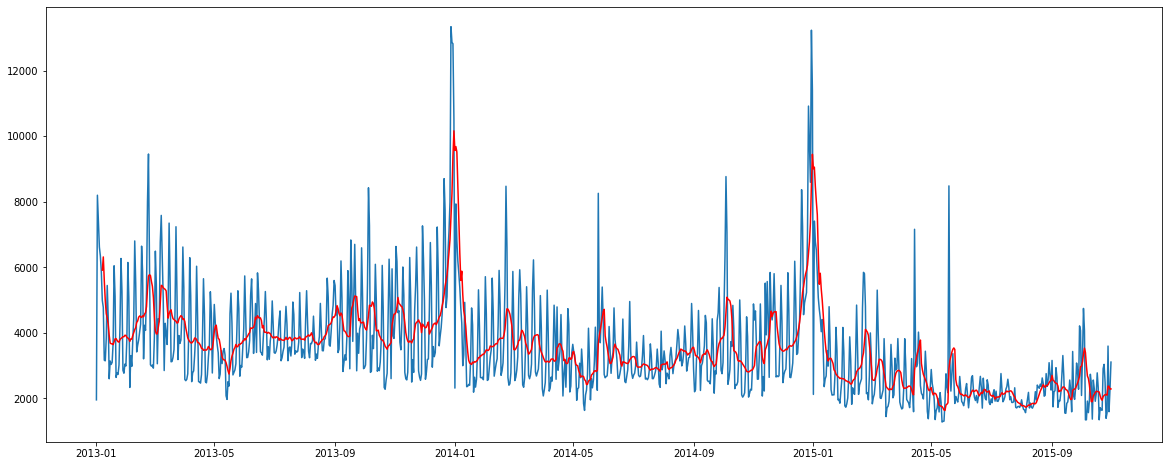

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(item_cnt_day_agg)
ax.plot(item_cnt_day_agg_smoothed, c="red")

In [62]:
item_cnt_month_agg = sales_train_by_month.groupby("date")["item_cnt_month"].sum()

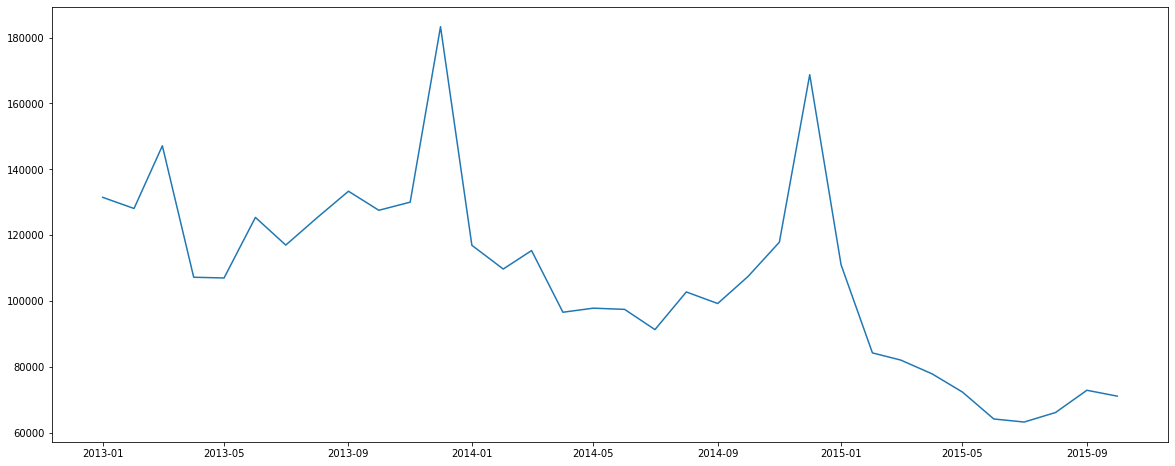

In [63]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(item_cnt_month_agg)

In [64]:
item_cnt_month_agg = item_cnt_month_agg.reset_index()
item_cnt_month_agg["year"] = item_cnt_month_agg["date"].dt.year
item_cnt_month_agg["month"] = item_cnt_month_agg["date"].dt.month

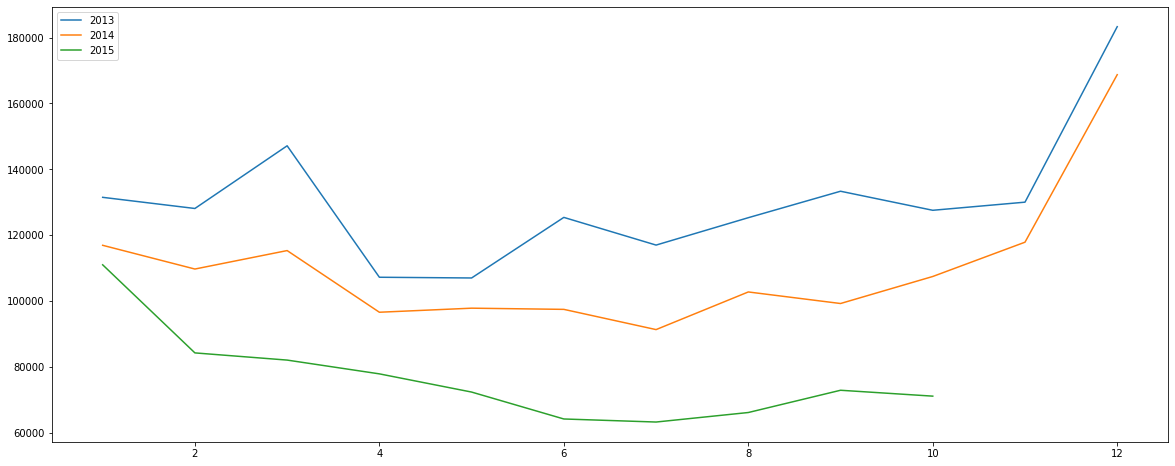

In [65]:
fig, ax = plt.subplots(figsize=(20, 8))
for year in item_cnt_month_agg["year"].unique():
    ax.plot(item_cnt_month_agg.loc[item_cnt_month_agg["year"] == year, "month"], item_cnt_month_agg.loc[item_cnt_month_agg["year"] == year, "item_cnt_month"], label=year)
ax.legend()

The negative trend is apparent, with some seasonal peaks in March and December.

In [68]:
sales_train_by_month.describe(include="all")

shop_id       item_id                 date  mean_item_price  \
count   1.609124e+06  1.609124e+06              1609124     1.609124e+06   
unique           NaN           NaN                   34              NaN   
top              NaN           NaN  2013-12-01 00:00:00              NaN   
freq             NaN           NaN                66276              NaN   
first            NaN           NaN  2013-01-01 00:00:00              NaN   
last             NaN           NaN  2015-10-01 00:00:00              NaN   
mean    3.280585e+01  1.068099e+04                  NaN     7.897548e+02   
std     1.653701e+01  6.238883e+03                  NaN     1.552415e+03   
min     0.000000e+00  0.000000e+00                  NaN     9.000000e-02   
25%     2.100000e+01  5.045000e+03                  NaN     1.990000e+02   
50%     3.100000e+01  1.049700e+04                  NaN     3.990000e+02   
75%     4.700000e+01  1.606000e+04                  NaN     8.985000e+02   
max     5.900000e+01  2.216900e+04                  NaN     3.079800e+05   

        median_item_price  item_cnt_month  \
count        1.609124e+06    1.609124e+06   
unique                NaN             NaN   
top                   NaN             NaN   
freq                  NaN             NaN   
first                 NaN             NaN   
last                  NaN             NaN   
mean         7.893331e+02    2.267200e+00   
std          1.553203e+03    8.649882e+00   
min          9.000000e-02   -2.200000e+01   
25%          1.990000e+02    1.000000e+00   
50%          3.990000e+02    1.000000e+00   
75%          8.985000e+02    2.000000e+00   
max          3.079800e+05    2.253000e+03   

                                                item_name  item_category_id  \
count                                             1609124      1.609124e+06   
unique                                              21807               NaN   
top     Playstation Store пополнение бумажника: Карта ...               NaN   
freq                                                 1452               NaN   
first                                                 NaN               NaN   
last                                                  NaN               NaN   
mean                                                  NaN      4.154192e+01   
std                                                   NaN      1.632365e+01   
min                                                   NaN      0.000000e+00   
25%                                                   NaN      3.000000e+01   
50%                                                   NaN      4.000000e+01   
75%                                                   NaN      5.500000e+01   
max                                                   NaN      8.300000e+01   

                                             item_name_en item_category_name  \
count                                             1609124            1609124   
unique                                              21793                 84   
top     Playstation Store replenishment wallet: Map pa...         Кино - DVD   
freq                                                 1452             336088   
first                                                 NaN                NaN   
last                                                  NaN                NaN   
mean                                                  NaN                NaN   
std                                                   NaN                NaN   
min                                                   NaN                NaN   
25%                                                   NaN                NaN   
50%                                                   NaN                NaN   
75%                                                   NaN                NaN   
max                                                   NaN                NaN   

       item_category_name_en                shop_name  \
count                1609124    

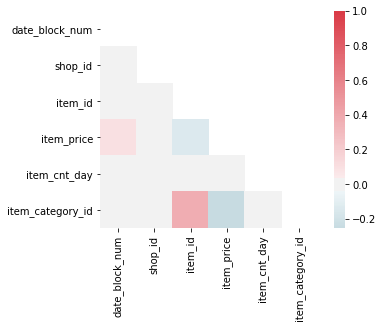

In [69]:
corr = sales_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, center=0)

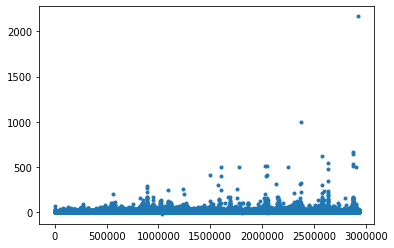

In [71]:
plt.plot(sales_train['item_cnt_day'], '.')

In [72]:
test_sample = test.sample(frac=0.01)
sales_train_by_month_sample = sales_train_by_month.sample(frac=0.01)

Text(0, 0.5, 'item_id')

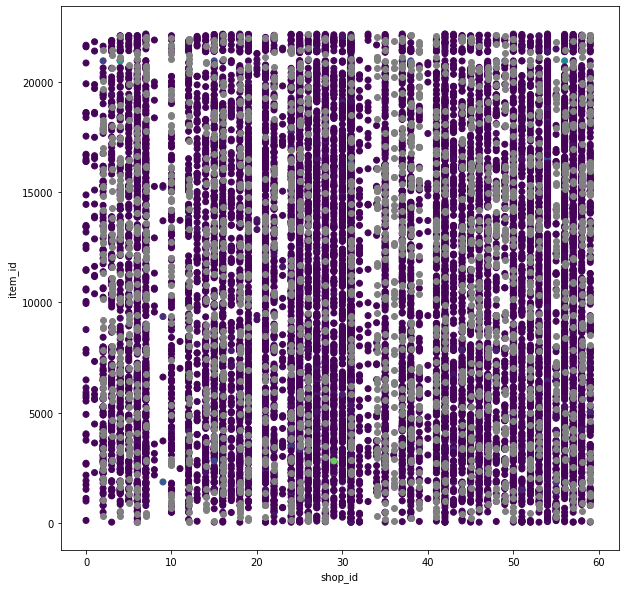

In [80]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(sales_train_by_month_sample["shop_id"], sales_train_by_month_sample["item_id"], 
           c=sales_train_by_month_sample["item_cnt_month"])
ax.scatter(test_sample["shop_id"], test_sample["item_id"], c="gray")
ax.set_xlabel("shop_id")
ax.set_ylabel("item_id")

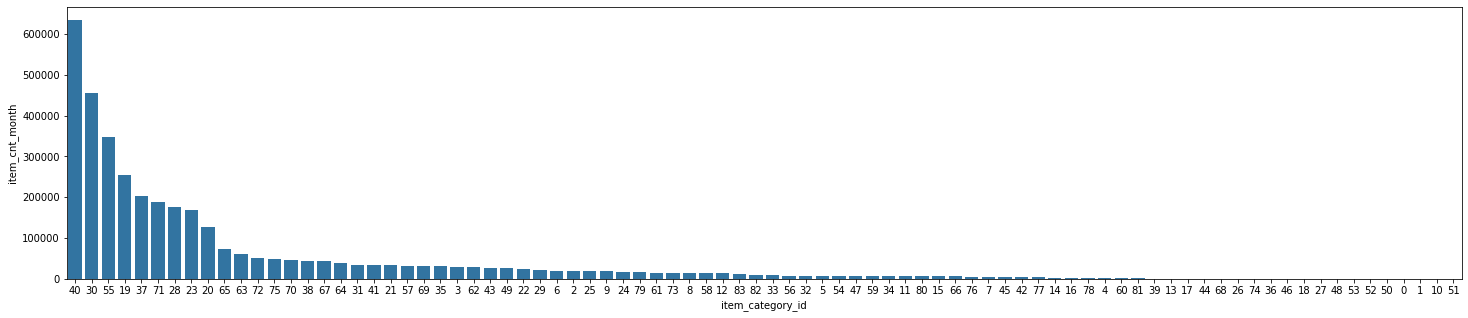

In [81]:
item_cnt_by_category_id = sales_train_by_month.groupby("item_category_id")["item_cnt_month"].sum().reset_index().sort_values("item_cnt_month", ascending=False)
fig, ax = plt.subplots(figsize = (25, 5))
sns.barplot(x='item_category_id', y="item_cnt_month", data=item_cnt_by_category_id, order=item_cnt_by_category_id["item_category_id"], color="#1f77b4")

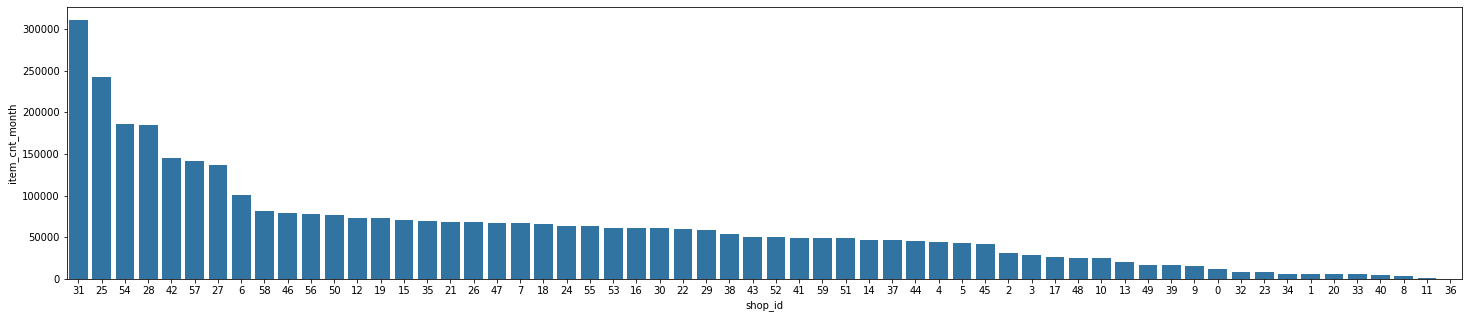

In [82]:
item_cnt_by_shop_id = sales_train_by_month.groupby("shop_id")["item_cnt_month"].sum().reset_index().sort_values("item_cnt_month", ascending=False)
fig, ax = plt.subplots(figsize = (25, 5))
sns.barplot(x="shop_id", y="item_cnt_month", data=item_cnt_by_shop_id, order=item_cnt_by_shop_id["shop_id"], color="#1f77b4")

# Explore item counts

In [83]:
(sales_train["item_cnt_day"] == 0).value_counts(normalize=True)

False    1.0
Name: item_cnt_day, dtype: float64

Training data don't consist explicit 0 - if there were no sales on the day, the row is absent.

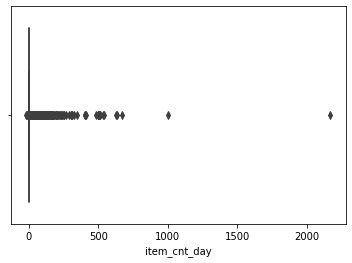

In [84]:
sns.boxplot(sales_train["item_cnt_day"])

In [85]:
sales_train \
    .sort_values("item_cnt_day", ascending=False) \
    .head(20)

date  date_block_num  shop_id  item_id   item_price  \
2928870 2015-10-28              33       12    11373     0.908714   
2371900 2015-01-15              24       12    20949     4.000000   
2881273 2015-09-30              32       12     9248  1692.526123   
2882183 2015-09-30              32       55     9249  1702.825806   
2578693 2015-04-14              27       12     3731  1904.548096   
2640163 2015-05-19              28       12    11373   155.192947   
2880957 2015-09-29              32       55     9249  1500.000000   
2029352 2014-10-02              21       12     9242  1500.000000   
2051782 2014-10-09              21       55    19437   899.000000   
2879875 2015-09-29              32       12     9248  1500.000000   
1605187 2014-04-22              15       27     8057  1200.000000   
1780261 2014-06-28              17       25    20949     5.000000   
2247018 2014-12-19              23       12    20949     4.000000   
2905380 2015-10-14              33       12    20949     4.000000   
2640152 2015-05-19              28       12    10209  1499.000000   
2051783 2014-10-09              21       55    19445  1249.000000   
1500481 2014-03-15              14       24    20949     5.000000   
2039422 2014-10-04              21       55    19437   899.000000   
1607157 2014-04-23              15       27     8057  1200.000000   
2640161 2015-05-19              28       12    11370   171.661804   

         item_cnt_day                                          item_name  \
2928870          2169               Доставка до пункта выдачи (Boxberry)   
2371900          1000  Фирменный пакет майка 1С Интерес белый (34*42)...   
2881273           669  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [...   
2882183           637  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...   
2578693           624          Grand Theft Auto V [PC, русские субтитры]   
2640163           539               Доставка до пункта выдачи (Boxberry)   
2880957           533  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...   
2029352           512  Билет "ИгроМир 2014" (на один день (отдельно -...   
2051782           508     Средиземье: Тени Мордора [PC, Цифровая версия]   
2879875           504  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [...   
1605187           502                                   iTunes 1500 руб.   
1780261           501  Фирменный пакет майка 1С Интерес белый (34*42)...   
2247018           500  Фирменный пакет майка 1С Интерес белый (34*42)...   
2905380           500  Фирменный пакет майка 1С Интерес белый (34*42)...   
2640152           480        Ведьмак 3: Дикая охота [PC, русская версия]   
2051783           412  Средиземье: Тени Мордора. Premium Edition [PC,...   
1500481           405  Фирменный пакет майка 1С Интерес белый (34*42)...   
2039422           401     Средиземье: Тени Мордора [PC, Цифровая версия]   
1607157           401                                   iTunes 1500 руб.   
2640161           343                               Доставка (по Москве)   

         item_category_id                                       item_name_en  \
2928870                 9          Delivery to the delivery point (Boxberry)   
2371900                71  Corporate package white shirt 1C Interest (34 ...   
2881273                80  Ticket "IgroMir 2015" - October 3, 2015 (site)...   
2882183                 8  Ticket "IgroMir 2015" - October 3, 2015 (websi...   
2578693                30         Grand Theft Auto V [PC, Russian subtitles]   
2640163                 9          Delivery to the delivery point (Boxberry)   
2880957                 8  Ticket "IgroMir 2015" - October 3, 2015 (websi...   
2029352                 8  Билет "ИгроМир 2014" (на один день (отдельно -...   
2051782                31  Middle-earth: Shadow of Mordor [PC, Digital Ve...   
2879875                80  Ticket "IgroMir 2015" - October 3, 2015 (site)...   
1605187                32                                iTunes 1500 rubles.   
1780261

In [86]:
sales_train \
    .sort_values("item_cnt_day", ascending=False).head(20) \
    [["item_name", "item_name_en", "item_category_name", "item_category_name_en"]] \
    .drop_duplicates()

item_name  \
2928870               Доставка до пункта выдачи (Boxberry)   
2371900  Фирменный пакет майка 1С Интерес белый (34*42)...   
2881273  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) [...   
2882183  Билет "ИгроМир 2015" - 3 октября 2015 (сайт) У...   
2578693          Grand Theft Auto V [PC, русские субтитры]   
2029352  Билет "ИгроМир 2014" (на один день (отдельно -...   
2051782     Средиземье: Тени Мордора [PC, Цифровая версия]   
1605187                                   iTunes 1500 руб.   
2640152        Ведьмак 3: Дикая охота [PC, русская версия]   
2051783  Средиземье: Тени Мордора. Premium Edition [PC,...   
2640161                               Доставка (по Москве)   

                                              item_name_en  \
2928870          Delivery to the delivery point (Boxberry)   
2371900  Corporate package white shirt 1C Interest (34 ...   
2881273  Ticket "IgroMir 2015" - October 3, 2015 (site)...   
2882183  Ticket "IgroMir 2015" - October 3, 2015 (websi...   
2578693         Grand Theft Auto V [PC, Russian subtitles]   
2029352  Билет "ИгроМир 2014" (на один день (отдельно -...   
2051782  Middle-earth: Shadow of Mordor [PC, Digital Ve...   
1605187                                iTunes 1500 rubles.   
2640152     The Witcher 3: Wild Hunt [PC, Russian version]   
2051783  Middle-earth: Shadow of Mordor. Premium Editio...   
2640161                                  Delivery (Moscow)   

                               item_category_name  \
2928870                           Доставка товара   
2371900  Подарки - Сумки, Альбомы, Коврики д/мыши   
2881273                        Служебные - Билеты   
2882183                            Билеты (Цифра)   
2578693             Игры PC - Стандартные издания   
2029352                            Билеты (Цифра)   
2051782                           Игры PC - Цифра   
1605187         Карты оплаты (Кино, Музыка, Игры)   
2640152          Игры PC - Дополнительные издания   
2051783                           Игры PC - Цифра   
2640161                           Доставка товара   

                        item_category_name_en  
2928870                     Delivery of goods  
2371900  Gifts - Bags, Albums, Mats d / mouse  
2881273                   Utilities - Tickets  
2882183                      Tickets (digits)  
2578693           Games PC - Standard Edition  
2029352                      Tickets (digits)  
2051782                    Games PC - Digital  
1605187   Payment card (Movies, Music, Games)  
2640152    Games PC - Additional publications  
2051783                    Games PC - Digital  
2640161                     Delivery of goods

- The top outlier seems to be some paid delivery service. The second top is the bag. 
- The 3rd, 4th, 7th, 8th, 10th rows are the tickets for the same event (in two consecutive years) - IgroMir - which is some large-scale annual exhibition of computer and video games in Russia which in years 2013-2015 was held in October (tickets were probably sold much earlier). 
- The other daily outliers were computer games (GTA, Middle-earth: Shadow of Mordor, The Witcher 3: Wild Hunt), iTunes payment card and Delivery Service (in Moscow only). This indicates that the number of items sold can vary according to some periodic (like IgroMir) or non-periodic events like the release of a popular computer game.

/home/kuba/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


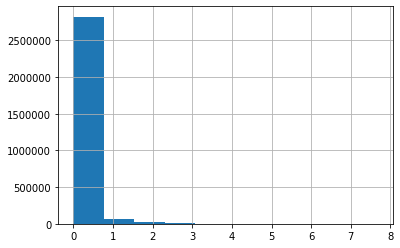

In [87]:
np.log(sales_train["item_cnt_day"]).hist()

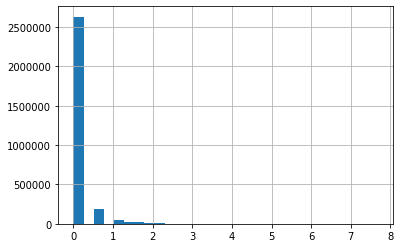

In [88]:
np.log(sales_train["item_cnt_day"]).hist(bins = 30)

In [89]:
sales_train_by_month["item_cnt_cumsum"] = sales_train_by_month \
    .sort_values("date") \
    .groupby("item_id") \
    ["item_cnt_month"] \
    .cumsum()

In [90]:
df_item_cnt_cumsum = sales_train_by_month \
    .groupby(["date", "item_id"]) \
    ["item_cnt_month"] \
    .sum() \
    .groupby("item_id") \
    .cumsum() \
    .reset_index()

Text(0, 0.5, 'Cumulative sum of items sold')

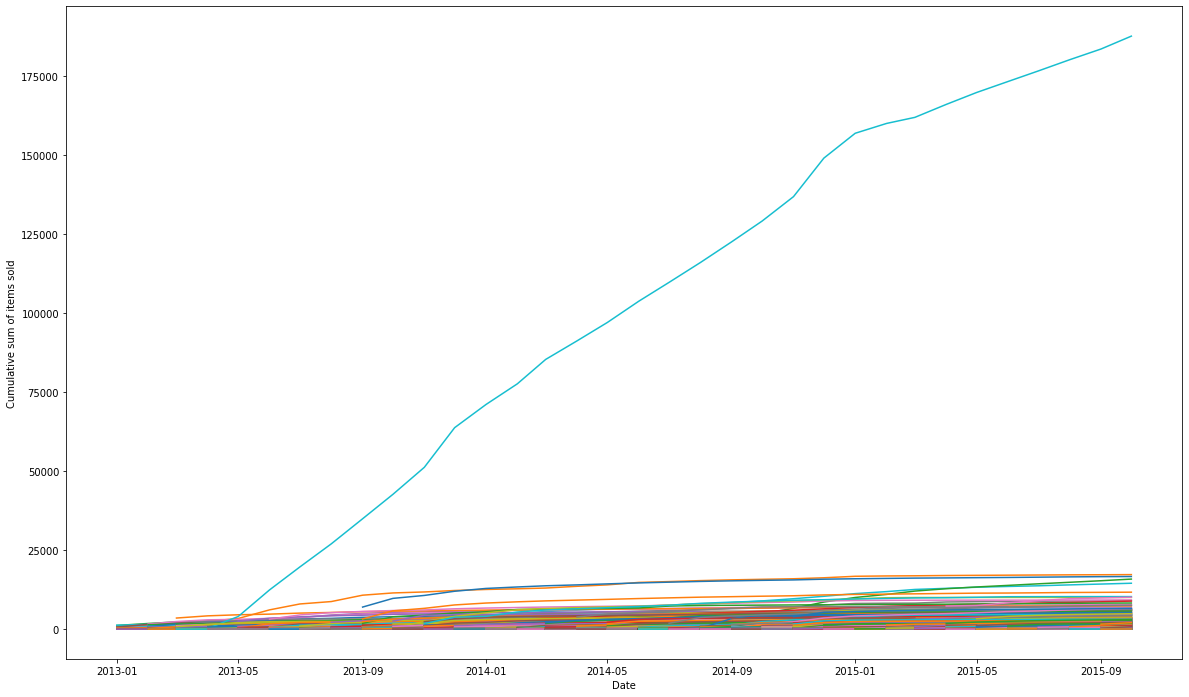

In [91]:
fig, ax = plt.subplots(figsize=(20, 12))
for i in df_item_cnt_cumsum["item_id"].unique():
    ax.plot(df_item_cnt_cumsum.loc[df_item_cnt_cumsum["item_id"] == i, "date"], 
            df_item_cnt_cumsum.loc[df_item_cnt_cumsum["item_id"] == i, "item_cnt_month"],
            label=i)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative sum of items sold")

There's two things that strikes immedietaly from the plot:

- There's one item that is sold predominantly (however, its predicted value be clipped to 20 anyway)
- There are plenty of items that are no more in sold (apparent steady line at the end)

In [92]:
df_item_cnt_cumsum.loc[df_item_cnt_cumsum["item_cnt_month"] == df_item_cnt_cumsum["item_cnt_month"].max(),
                       "item_id"]

233589    20949
Name: item_id, dtype: int64

In [93]:
items.loc[items["item_id"] == 20949, "item_name"].values

array(['Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм'],
      dtype=object)

According to google translator this item is just a branded plastic bag, which makes total sense as it's probably sold almost with every order.

In [94]:
df_shop_cnt_cumsum = sales_train_by_month.groupby(["date", "shop_id"])["item_cnt_month"].sum().groupby("shop_id").cumsum().reset_index()

Text(0, 0.5, 'Cumulative sum of items sold by shop')

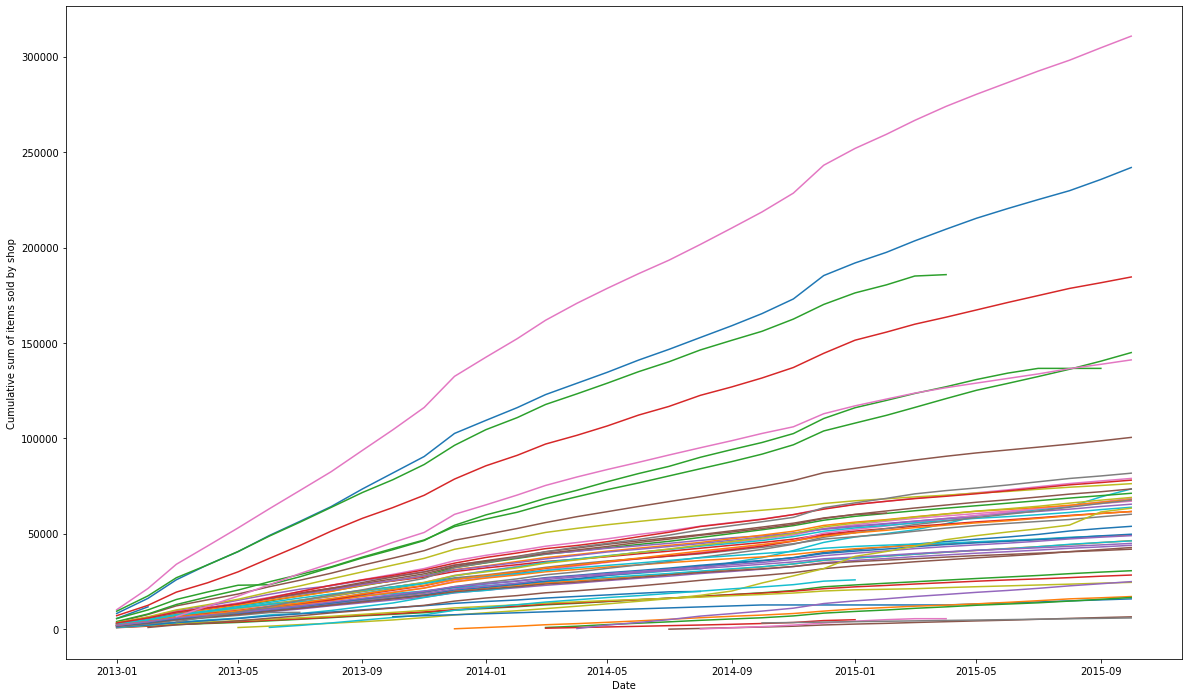

In [95]:
fig, ax = plt.subplots(figsize=(20, 12))
for i in df_shop_cnt_cumsum["shop_id"].unique():
    ax.plot(df_shop_cnt_cumsum.loc[df_shop_cnt_cumsum["shop_id"] == i, "date"], 
            df_shop_cnt_cumsum.loc[df_shop_cnt_cumsum["shop_id"] == i, "item_cnt_month"],
            label=i)
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative sum of items sold by shop")

There are some shops which are probably already closed. On other hand, some were opened after 2013.

Based on two previous plots, we can probably predict 0 for all the items which are not sold anymore and shops that are closed (if they appear in the test set). However, these missing values could be for other reason as well. It'll be probably a good idea to see if these are the only missing values in the data or we have some missing values for another reason as well.

In [96]:
sales_train = sales_train.merge(test, how="left", on=["shop_id", "item_id"])

In [97]:
needed_combinations = pd.DataFrame(list(itertools.product(sales_train_by_month["date"].unique(), test["ID"].unique())),
                                   columns=["date", "ID"])

In [98]:
needed_combinations = needed_combinations.merge(sales_train_by_month, how="left", on=["date", "ID"])

In [99]:
needed_combinations.isnull().sum(axis=0)

date                           0
ID                             0
shop_id                  6682641
item_id                  6682641
mean_item_price          6682641
median_item_price        6682641
item_cnt_month           6682641
item_name                6682641
item_category_id         6682641
item_name_en             6682641
item_category_name       6682641
item_category_name_en    6682641
shop_name                6682641
shop_name_en             6682641
item_cnt_cumsum          6682641
dtype: int64

In [100]:
needed_combinations.shape

(7282800, 15)

In [101]:
needed_combinations.dtypes

date                     datetime64[ns]
ID                                int64
shop_id                         float64
item_id                         float64
mean_item_price                 float32
median_item_price               float32
item_cnt_month                  float64
item_name                        object
item_category_id                float64
item_name_en                     object
item_category_name               object
item_category_name_en            object
shop_name                        object
shop_name_en                     object
item_cnt_cumsum                 float64
dtype: object

In [102]:
needed_combinations["date"] = needed_combinations["date"].dt.date

In [103]:
item_cnt_month_by_item = needed_combinations.pivot_table(values="item_cnt_month", index="item_id", columns="date")

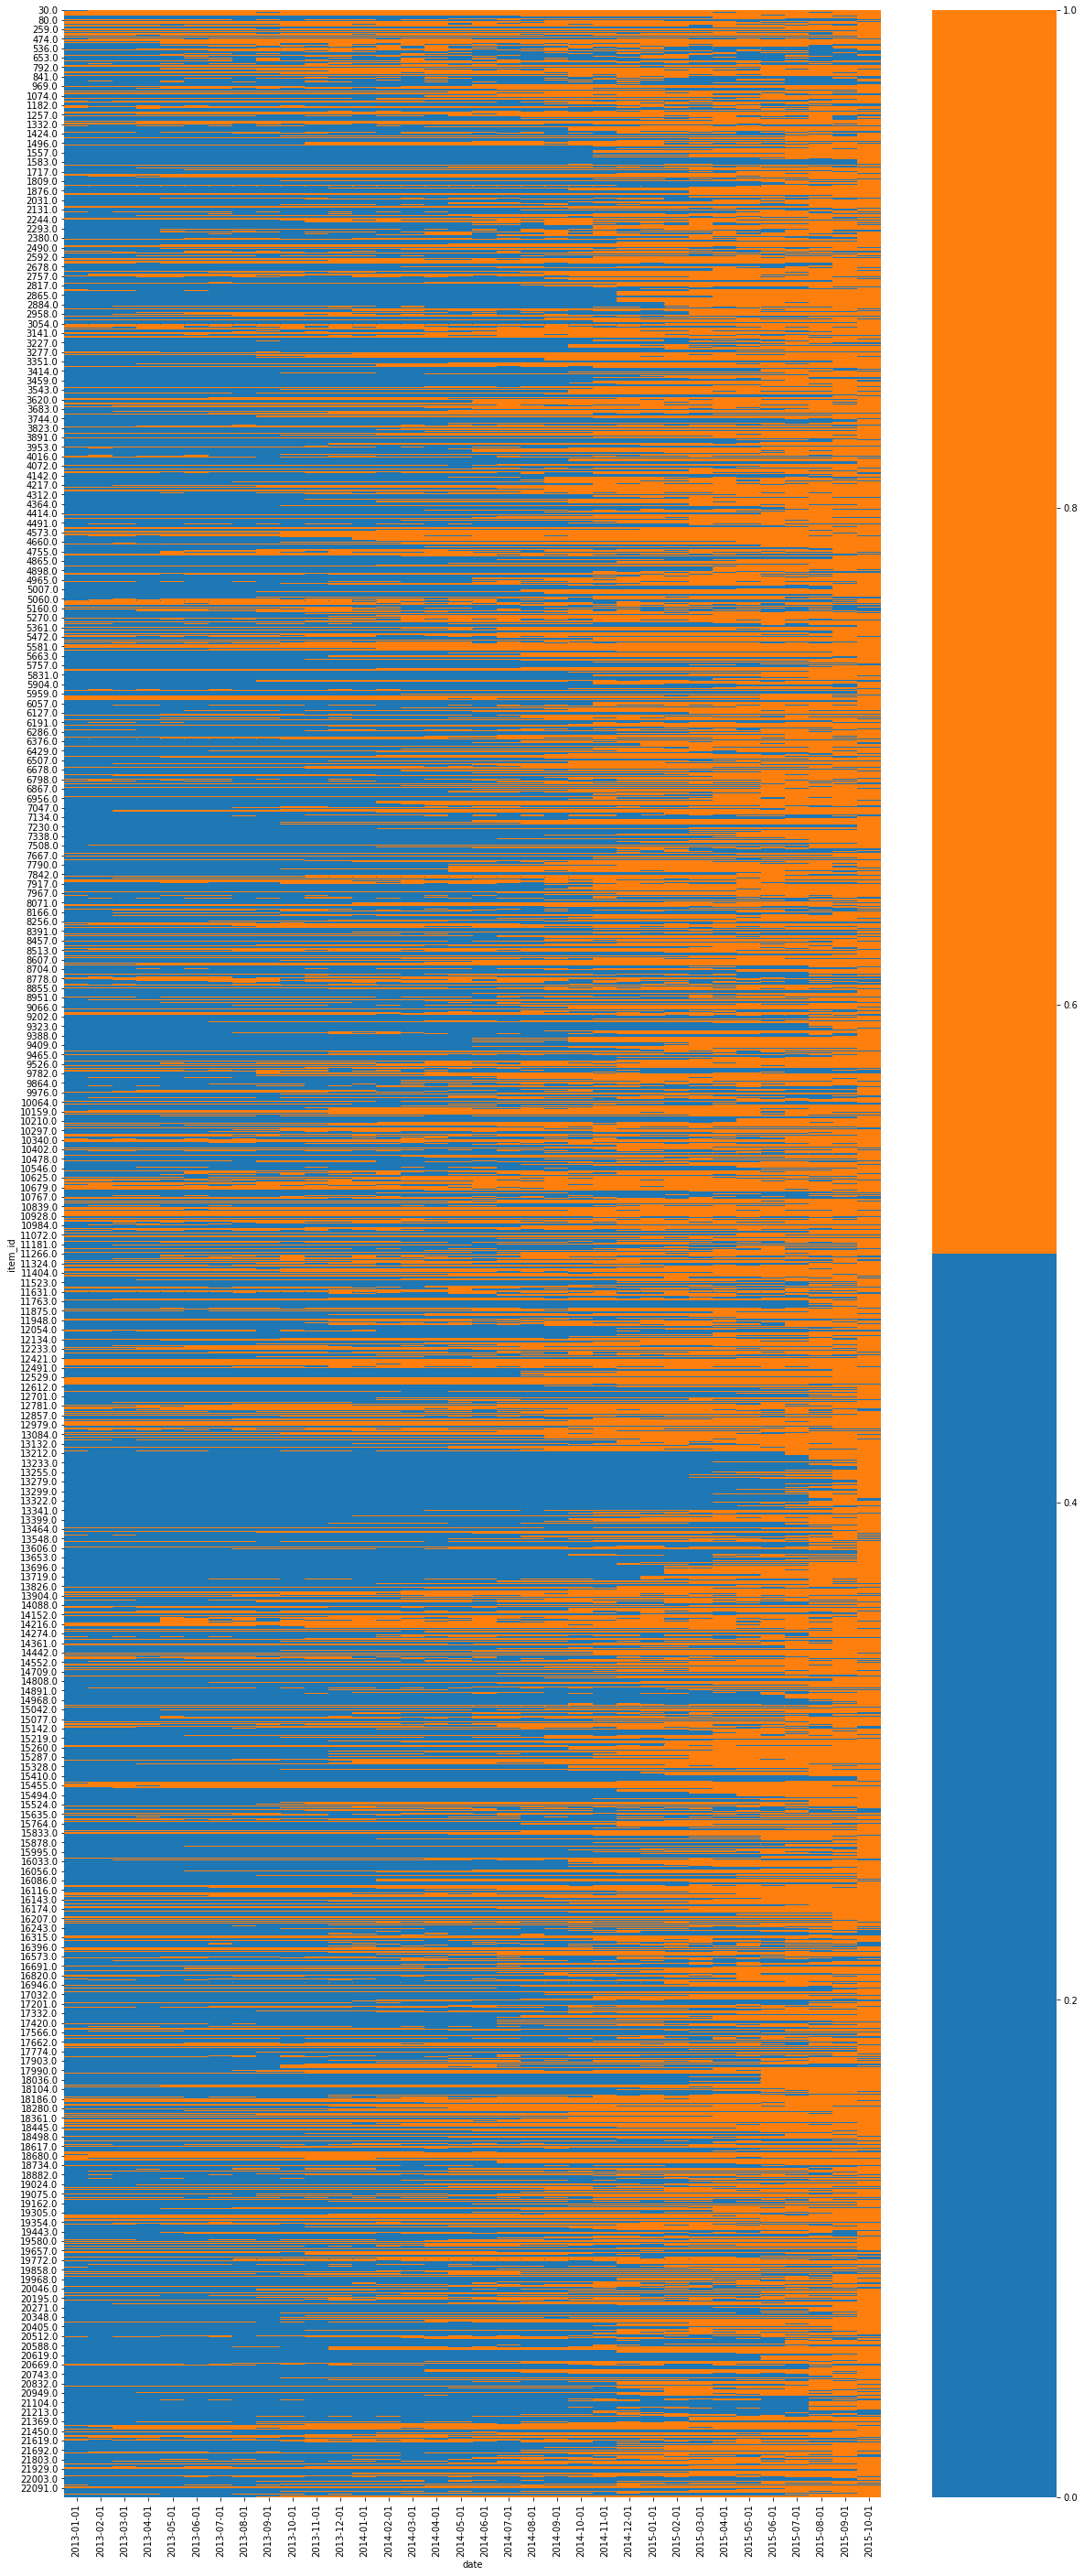

In [104]:
fig, ax = plt.subplots(figsize=(20, 50))
ax = sns.heatmap(item_cnt_month_by_item.notnull(), cmap=sns.color_palette(n_colors=2))

Plenty of missing values with irregular patterns, but it seems that some items were released after the data collection started and some of them are not sold anymore.

In [105]:
item_cnt_month_by_item = item_cnt_month_by_item.loc[item_cnt_month_by_item.apply(lambda row: row.first_valid_index(), axis=1).sort_values().index, :]

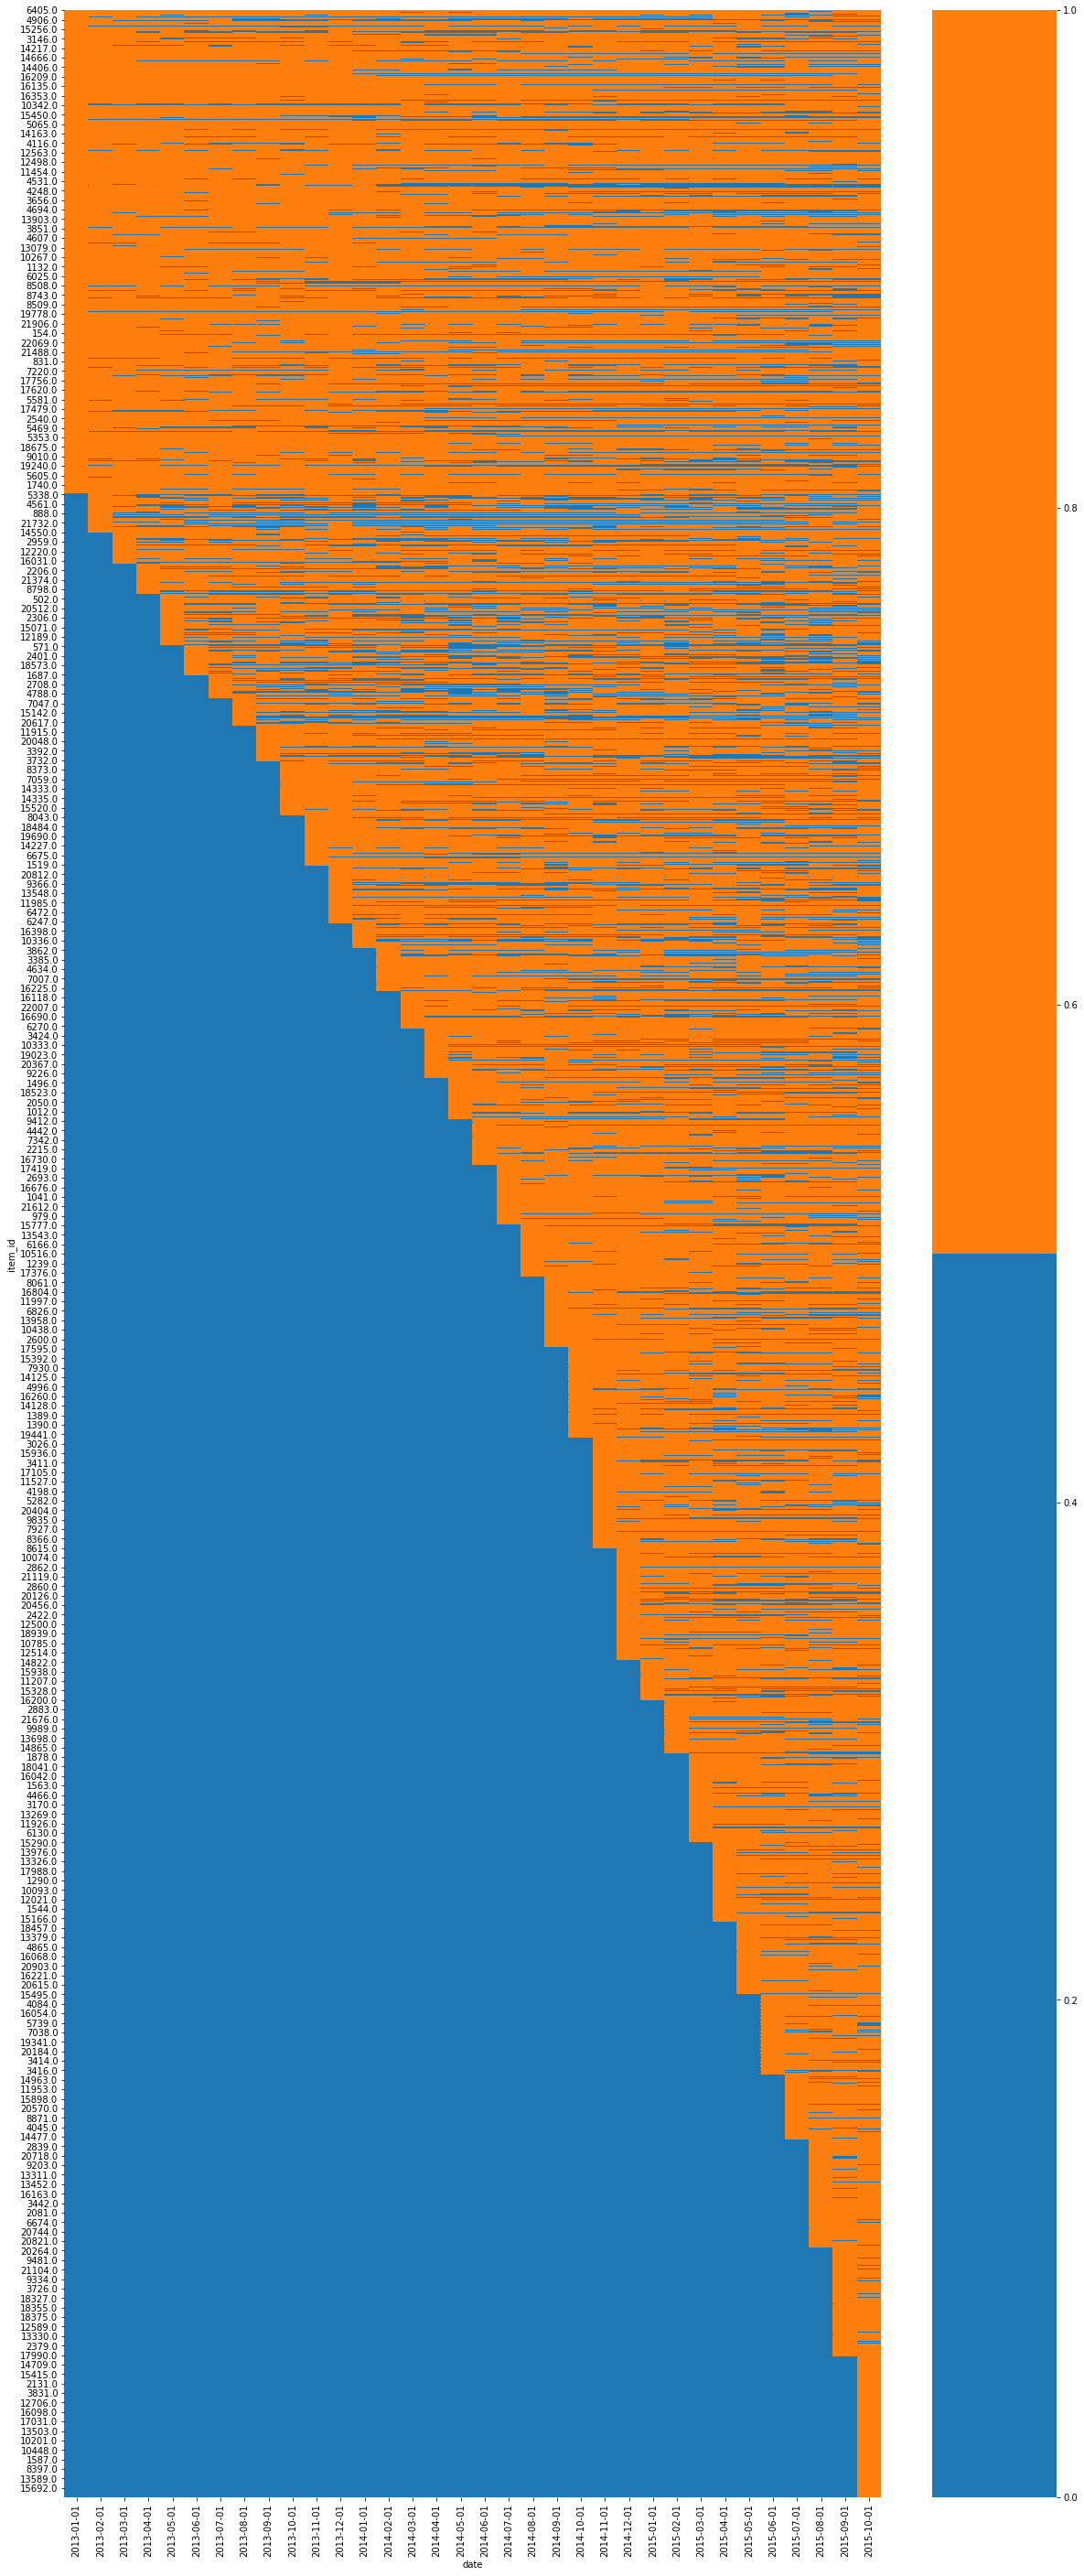

In [106]:
fig, ax = plt.subplots(figsize=(20, 50))
ax = sns.heatmap(item_cnt_month_by_item.notnull(), cmap=sns.color_palette(n_colors=2))

In [107]:
item_cnt_month_by_item = item_cnt_month_by_item.loc[item_cnt_month_by_item.apply(lambda row: row.last_valid_index(), axis=1).sort_values().index]

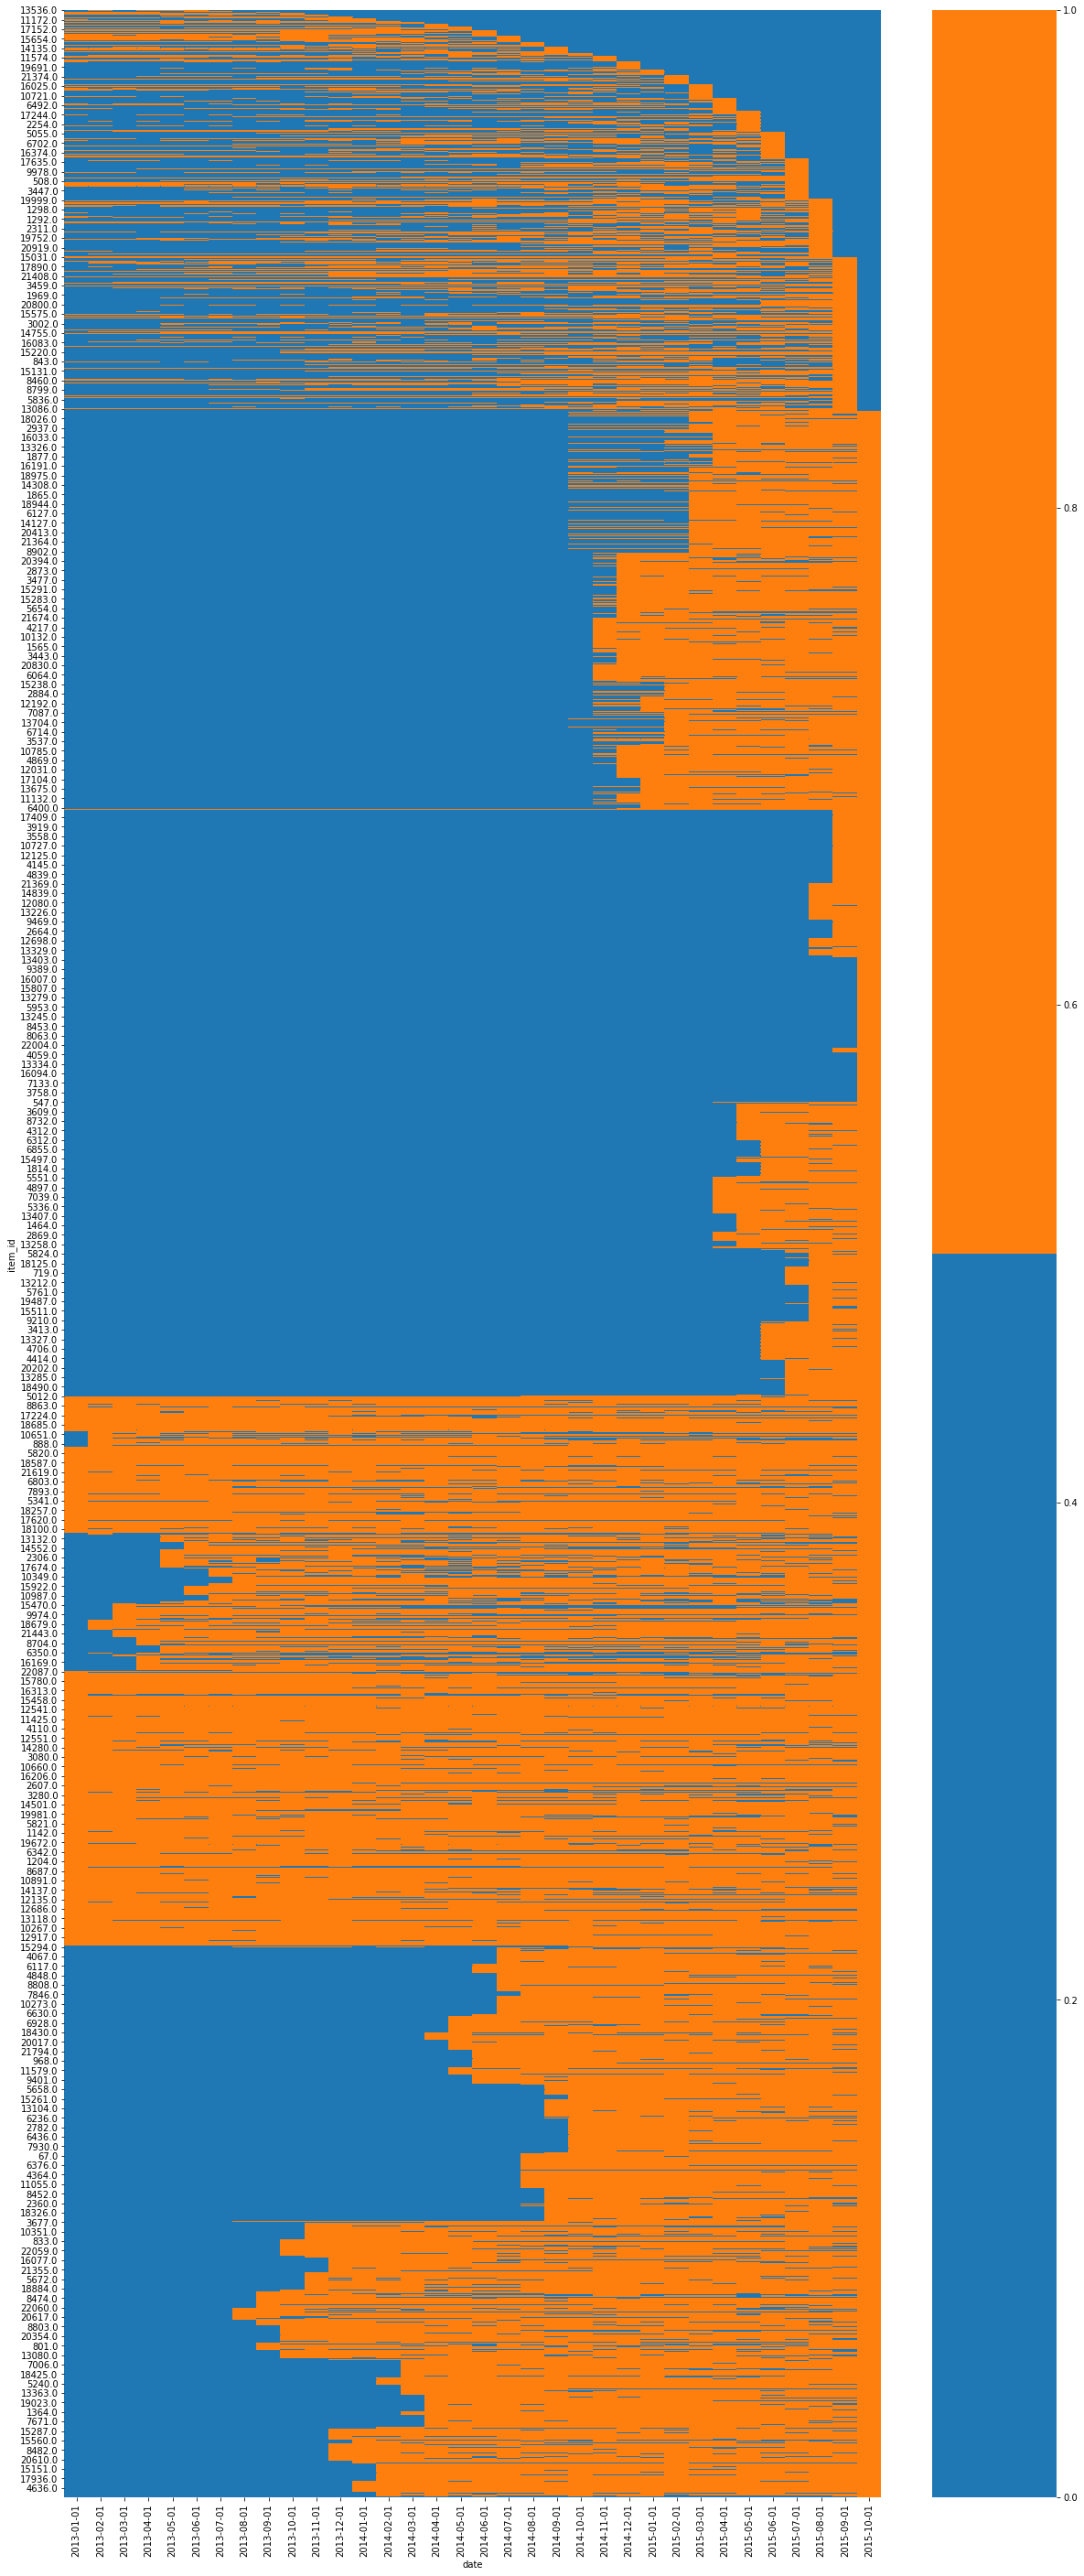

In [108]:
fig, ax = plt.subplots(figsize=(20, 50))
ax = sns.heatmap(item_cnt_month_by_item.notnull(), cmap=sns.color_palette(n_colors=2))

There is some parts of items that is probably not sold anymore. However, some items were sold again even after few months break. This means that predicting 0 for items that seems to be not in sale for a couple of months isn't probably the best solution. However, the features like first valid index and last valid index can be useful.

In [109]:
sales_train_by_month.loc[sales_train_by_month["item_cnt_month"] < 0, "item_cnt_month"].value_counts()

-1     883
-2      26
-4       2
-22      1
-13      1
-6       1
-5       1
Name: item_cnt_month, dtype: int64

In [110]:
sales_train.loc[sales_train["item_cnt_day"] < 0, "item_cnt_day"].value_counts()

-1     7252
-2       78
-3       14
-5        4
-4        3
-6        2
-9        1
-22       1
-16       1
Name: item_cnt_day, dtype: int64

These are probably returned items. We can either remove those negative values (set to 0), but I believe it would create a bias (as if more items are sold than returned the value is positive and those returned items are still present in total value). Probably better to leave them as they are.

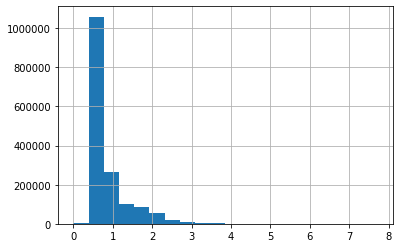

In [111]:
np.log1p(sales_train_by_month.loc[sales_train_by_month["item_cnt_month"] >= 0, "item_cnt_month"]).hist(bins=20)

In [112]:
needed_combinations.groupby("date")["item_cnt_month"].agg(lambda x: x.isnull().sum() / len(x))

../src/read_data.py:1: RuntimeWarning: invalid value encountered in long_scalars
  import pandas as pd


date
2013-01-01    0.963403
2013-02-01    0.961611
2013-03-01    0.954514
2013-04-01    0.959528
2013-05-01    0.958669
2013-06-01    0.955682
2013-07-01    0.952227
2013-08-01    0.949108
2013-09-01    0.951237
2013-10-01    0.947232
2013-11-01    0.942460
2013-12-01    0.922241
2014-01-01    0.933763
2014-02-01    0.935037
2014-03-01    0.928142
2014-04-01    0.931933
2014-05-01    0.926746
2014-06-01    0.920756
2014-07-01    0.916774
2014-08-01    0.907493
2014-09-01    0.916013
2014-10-01    0.907754
2014-11-01    0.895294
2014-12-01    0.853978
2015-01-01    0.879421
2015-02-01    0.886937
2015-03-01    0.882796
2015-04-01    0.894883
2015-05-01    0.891783
2015-06-01    0.886928
2015-07-01    0.876545
2015-08-01    0.864795
2015-09-01    0.876345
2015-10-01    0.866106
Name: item_cnt_month, dtype: float64

# Explore the price

In [113]:
sales_train["item_price"].value_counts()

299.000000     291352
399.000000     242603
149.000000     218432
199.000000     184044
349.000000     101461
                ...  
2155.000000         1
2154.250000         1
291.666656          1
2153.699951         1
511.997498          1
Name: item_price, Length: 19992, dtype: int64

In [114]:
(100 * sales_train["item_price"] % 1).value_counts()

0.000000    2916225
0.500000       2437
0.007812       1487
0.003906       1257
0.999023       1221
             ...   
0.400024          1
0.399414          1
0.824219          1
0.387085          1
0.499969          1
Name: item_price, Length: 340, dtype: int64

In [115]:
((100 * sales_train["item_price"] % 1) > 0).value_counts(normalize=True)

False    0.993316
True     0.006684
Name: item_price, dtype: float64

Over 99% of products has a price which is an integer value, but there are some items with irregular decimals. I believe it may be an indication of some discount applied and therefore, and indication of occasional promotion.

In [116]:
irregular_decimals = (100 * sales_train["item_price"] % 1) > 0

In [117]:
irregular_decimals_dates = sales_train.loc[irregular_decimals, "date"].drop_duplicates()

In [118]:
(irregular_decimals_dates - irregular_decimals_dates.shift(1, fill_value="2012-12-31")).value_counts()

1 days    1034
Name: date, dtype: int64

/home/kuba/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


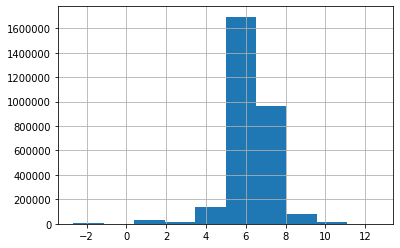

In [119]:
np.log(sales_train["item_price"]).hist()

In [120]:
sales_train.loc[sales_train["item_price"] < 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
482378 2013-05-15               4       32     2973        -1.0             1   

                                        item_name  item_category_id  \
482378  DmC Devil May Cry [PS3, русские субтитры]                19   

                                      item_name_en item_category_name  \
482378  DmC Devil May Cry [PS3, Russian subtitles]         Игры - PS3   

       item_category_name_en                   shop_name  \
482378           Games - PS3  Москва ТЦ "Серебряный Дом"   

                                 shop_name_en  ID  
482378  Moscow shopping center "Silver House" NaN

Seems like invalid value. We can deal with that later with some imputation method.

In [121]:
sales_train.loc[sales_train["item_id"] == 0]

date  date_block_num  shop_id  item_id  item_price  \
1955734 2014-09-01              20       54        0        58.0   

         item_cnt_day                                  item_name  \
1955734             1  ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D   

         item_category_id                  item_name_en item_category_name  \
1955734                40  ! POWER IN glamor (PLAST.) D         Кино - DVD   

        item_category_name_en        shop_name      shop_name_en  ID  
1955734           Movie - DVD  Химки ТЦ "Мега"  Khimki TC "Mega" NaN

In [122]:
sales_train["item_price"].describe(percentiles=np.arange(0.1, 1, 0.1)).apply(lambda x: format(x, 'g'))

count    2.93585e+06
mean         890.605
std          1726.46
min               -1
10%              149
20%              199
30%              299
40%              349
50%              399
60%              599
70%              799
80%             1199
90%             1999
max           307980
Name: item_price, dtype: object

In [123]:
sales_train.sort_values("item_price", ascending=False).head(20)

date  date_block_num  shop_id  item_id  item_price  \
1162675 2013-12-13              11       12     6066    307980.0   
889806  2013-09-17               8       12    11365     59200.0   
1514069 2014-03-20              14       25    13199     50999.0   
2404539 2015-01-29              24       12     7241     49782.0   
2915393 2015-10-20              33        3    13403     42990.0   
2920904 2015-10-23              33       42    13403     42990.0   
2930107 2015-10-29              33       12    13403     42990.0   
2915747 2015-10-20              33       22    13403     42990.0   
1003401 2013-10-24               9       12     7238     42000.0   
2915532 2015-10-20              33       12    13403     41990.0   
2918455 2015-10-22              33       18    13403     41990.0   
2916277 2015-10-20              33       38    13403     41990.0   
2918767 2015-10-22              33       28    13403     40991.0   
2159766 2014-11-20              22       12    14173     40900.0   
2930937 2015-10-29              33       42    13403     37991.0   
2926577 2015-10-26              33       25    13403     37991.0   
1589287 2014-04-16              15       14     5748     36990.0   
869815  2013-09-11               8       12     2410     36990.0   
1647471 2014-05-09              16        5     5748     36990.0   
1396336 2014-02-10              13       12     5748     36990.0   

         item_cnt_day                                          item_name  \
1162675             1                               Radmin 3  - 522 лиц.   
889806              1                                     Доставка (EMS)   
1514069             1            Коллекционные шахматы (Властелин Колец)   
2404539             1  UserGate Proxy & Firewall 6.X с модулем фильтр...   
2915393             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2920904             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2930107             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2915747             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
1003401             1        UserGate Proxy & Firewall 6.X до 100 сессий   
2915532             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2918455             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2916277             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2918767             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2159766             1   Лицензия 1С-Битрикс: Управление сайтом - Эксперт   
2930937             2  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2926577             1  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
1589287             1                   Photoshop 13 Windows Russian BOX   
869815              1  CorelDRAW Graphics Suite X6 - Small Business E...   
1647471             1                   Photoshop 13 Windows Russian BOX   
1396336             1                   Photoshop 13 Windows Russian BOX   

         item_category_id                                       item_name_en  \
1162675                75                               Radmin 3  - 522 лиц.   
889806                  9                                     Shipping (EMS)   
1514069                69                            Collector chess (Rings)   
2404539                75  UserGate Proxy & Firewall 6.X filtration modul...   
2915393                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2920904                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2930107                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2915747                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
1003401                75        UserGate Proxy & Firewall 6.X до 100 сессий   
2915532                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2918455                16  Комплект "Microsoft Xbox One 1TB  Limited Edit...   
2916277                16  К

The most expensive item was Radmin3 license sold probably in a package for 522 people. The second top item with respect to price was a delivery, which is a little bit weird, but feasible in case of an overseas delivery of the large order. Other most expensive items were either game consoles or highly-technical software.

In [124]:
item_price_stats = sales_train.groupby("item_id") \
    .agg({"item_price": [np.nanstd, np.mean, np.median, "count"], "shop_id": "nunique"})
item_price_stats.rename({"nunique": "n_shops"}, axis=1, inplace=True)
item_price_stats = item_price_stats.T.reset_index(level=0, drop=True).T
item_price_stats["dispersion"] = item_price_stats["nanstd"] ** 2 / item_price_stats["mean"]
item_price_stats.sort_values("dispersion", ascending=False).head(30)

nanstd          mean        median   count  n_shops   dispersion
item_id                                                                       
11365    4119.496582   1887.565430   1203.750000   242.0      1.0  8990.550379
13477    5368.354492  10194.000000  10194.000000     2.0      2.0  2827.077688
16854    1612.658325   1592.333374    349.000000    15.0     10.0  1633.242709
11369    1234.943359   1007.965454    669.000000   417.0      1.0  1513.033105
3875     1837.770508   2298.500000   2298.500000     2.0      2.0  1469.393274
14170    5813.875488  23157.000000  24900.000000     3.0      3.0  1459.651431
11370    1084.955933    822.165955    518.333313   624.0      1.0  1431.741815
20666    3181.980469   7749.000000   7749.000000     2.0      2.0  1306.620171
20724    1625.492798   2252.000000   2399.000000     3.0      2.0  1173.280122
1652     2763.270752   6540.538574   5078.000000    13.0      9.0  1167.436773
7132     1145.512939   1188.000000   1188.000000     2.0      2.0  1104.545366
4857     3657.156250  13546.000000  13546.000000     2.0      1.0   987.360980
5565     2117.143555   4555.333496   3333.000000     3.0      1.0   983.966780
11364    1225.181030   1589.191650   1103.500000    15.0      1.0   944.548479
5877     2304.231201   6031.933105   7699.000000    15.0      8.0   880.228831
16837     758.725586    663.500000    663.500000     2.0      1.0   867.617957
2784     2517.008789   7408.270020   6998.000000    20.0     15.0   855.170401
7982     3971.375244  18570.144531  16501.000000   321.0     49.0   849.310640
8847     1300.357300   2002.473633   2999.000000    19.0     13.0   844.420161
13473    3037.796875  11339.400391  12990.000000    10.0     10.0   813.818151
7904     2131.957031   5608.399902   4498.000000     5.0      5.0   810.434502
4987      637.103210    548.500000    548.500000     2.0      2.0   740.019145
19870     748.976624    786.500000    299.000000    12.0      7.0   713.243462
12118    3831.166504  21091.923828  21741.000000    84.0     35.0   695.898435
4603     1466.892944   3111.750000   3111.750000     2.0      2.0   691.499931
7944     2769.401611  11112.333008   9943.500000    12.0     10.0   690.186775
948       949.270996   1358.854614    999.000000   270.0     47.0   663.143367
18168     642.320740    636.129517    249.000000   122.0     41.0   648.572220
6664     2335.653076   8657.275391   9241.000000    44.0     17.0   630.137664
17717     830.026917   1094.625732    999.000000  9067.0     51.0   629.388349

In [125]:
sales_train.groupby("item_id")["shop_id"].nunique()

item_id
0         1
1         1
2         1
3         1
4         1
         ..
22165     1
22166     1
22167    49
22168     5
22169     1
Name: shop_id, Length: 21807, dtype: int64

There are a lot of items with really large dispersion from the mean value. Let's inspect few of them.

In [126]:
items[items["item_id"] == 11365]

item_name  item_id  item_category_id    item_name_en
11365  Доставка (EMS)    11365                 9  Shipping (EMS)

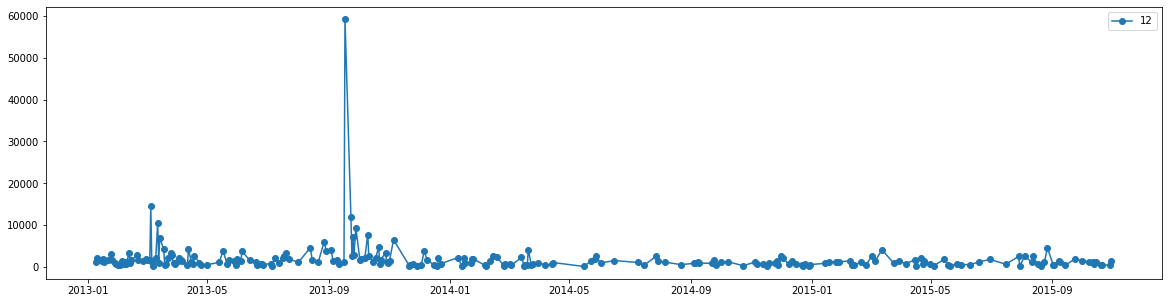

In [127]:
fig, ax = plt.subplots(figsize=(20, 5))
for id, shop_df in sales_train.sort_values("date").loc[sales_train["item_id"] == 11365].groupby('shop_id'):
    ax.plot(shop_df["date"],
            shop_df["item_price"], 
            "o-", label=id)
ax.legend()

This is certainly weird distribution of item price. There's few outliers so median value should be probably used if we want to aggregate values of `item_price`.

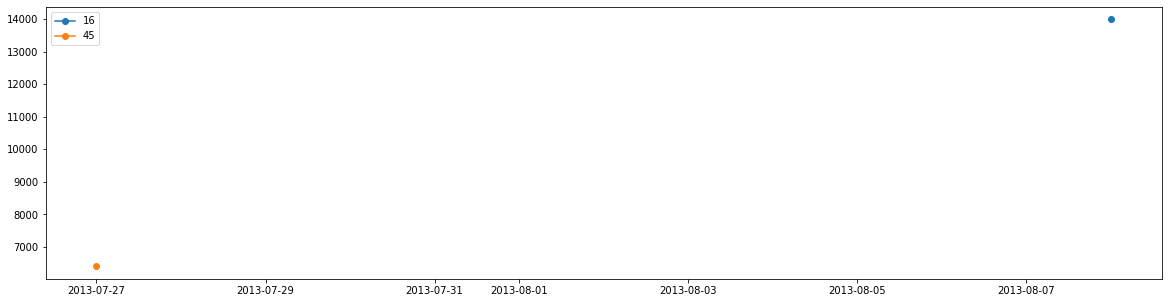

In [128]:
fig, ax = plt.subplots(figsize=(20, 5))
for id, shop_df in sales_train.sort_values("date").loc[sales_train["item_id"] == 13477].groupby('shop_id'):
    ax.plot(shop_df["date"],
            shop_df["item_price"], 
            "o-", label=id)
ax.legend()

In [129]:
sales_train.sort_values("date").loc[sales_train["item_id"] == 13477]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
718391 2013-07-27               6       45    13477      6398.0             1   
756191 2013-08-08               7       16    13477     13990.0            -1   

                                                item_name  item_category_id  \
718391  Комплект «Sony PS3 (320 Gb) (CECH-3008B)» + иг...                11   
756191  Комплект «Sony PS3 (320 Gb) (CECH-3008B)» + иг...                11   

                                             item_name_en  \
718391  Комплект «Sony PS3 (320 Gb) (CECH-3008B)» + иг...   
756191  Комплект «Sony PS3 (320 Gb) (CECH-3008B)» + иг...   

           item_category_name item_category_name_en             shop_name  \
718391  Игровые консоли - PS3   Game consoles - PS3  Самара ТЦ "ПаркХаус"   
756191  Игровые консоли - PS3   Game consoles - PS3      Коломна ТЦ "Рио"   

                shop_name_en  ID  
718391  Samara TC "Parkhaus" NaN  
756191      Kolomna TC "Rio" NaN

It's unlikely that the price was nearly doubled in less than two weaks, but maybe there were some promotion applied. 

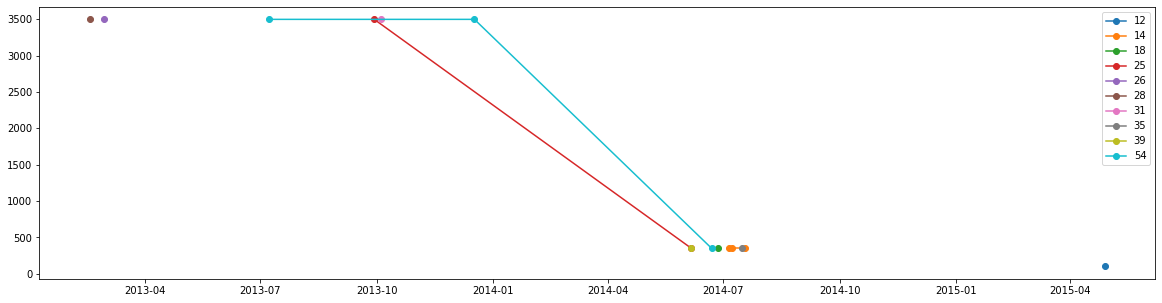

In [130]:
fig, ax = plt.subplots(figsize=(20, 5))
for id, shop_df in sales_train.sort_values("date").loc[sales_train["item_id"] == 16854].groupby('shop_id'):
    ax.plot(shop_df["date"],
            shop_df["item_price"], 
            "o-", label=id)
ax.legend()

Price of the item 16854 varies not only accross shops but also within the same shops.

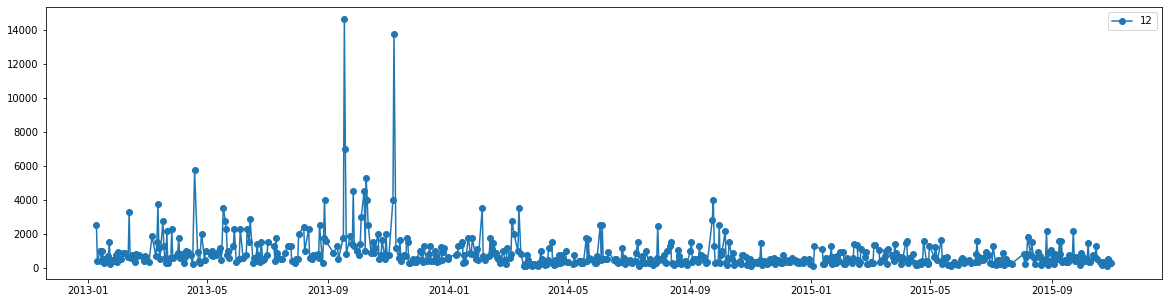

In [131]:
fig, ax = plt.subplots(figsize=(20, 5))
for id, shop_df in sales_train.sort_values("date").loc[sales_train["item_id"] == 11370].groupby('shop_id'):
    ax.plot(shop_df["date"],
            shop_df["item_price"], 
            "o-", label=id)
ax.legend()

As with first item 11365, we observe outliers in price.

In [132]:
sales_train.loc[sales_train["item_id"] == 11370, "shop_id"].drop_duplicates()

43089    12
Name: shop_id, dtype: int8